In [1]:
import numpy as np
import tensorflow as tf 
from tensorflow import keras
import matplotlib.pyplot as plt
from scipy import interpolate
from datetime import datetime
import os
import json
import pickle
# import tensorflow_addons as tfa ---- this might work on a non-Mac

# print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
# mirrored_strategy = tf.distribute.MirroredStrategy()

In [2]:
def upsample(dim_new, arr):
    dim_old = np.shape(arr)[0]
    assert np.shape(arr)[0] == np.shape(arr)[1]
    x = np.arange(dim_old)
    f = interpolate.interp2d(x, x, arr, kind='linear')
    xnew = np.linspace(0, dim_old, dim_new)
    ynew = np.linspace(0, dim_old, dim_new)
    return f(xnew, ynew)

def show_digits(X, y, i):
    fig, ax = plt.subplots(1, len(i), sharex=True)
    for k, j in enumerate(i):
        ax[k].imshow(X[j])
        ax[k].set_title(y[j])
        ax[k].axis('off')
    plt.tight_layout()
    plt.show()
    
def mse(x, y):
    x = np.reshape(x, (-1,))
    y = np.reshape(y, (-1,))
    return np.mean((x - y)**2)

def mae(x, y):
    x = np.reshape(x, (-1,))
    y = np.reshape(y, (-1,))
    return np.mean(np.abs(x - y))

# Data Generation
Instead of dividing into two train/validation/test sets as before for the logistic regression and subsequent classifiers, now we just do one split! As such, we will use the default splitting on MNIST.

In [3]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train, x_test = x_train[..., np.newaxis] / 255., x_test[..., np.newaxis] / 255.
y_train_old, y_test_old = y_train, y_test
y_train, y_test = y_train.astype(float) / 10.,  y_test.astype(float) / 10.
y_train, y_test = np.random.binomial(1, y_train), np.random.binomial(1, y_test)

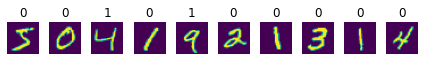

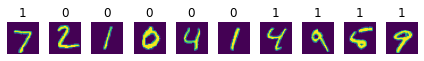

In [4]:
show_digits(x_train, y_train, range(10))
show_digits(x_test, y_test, range(10))

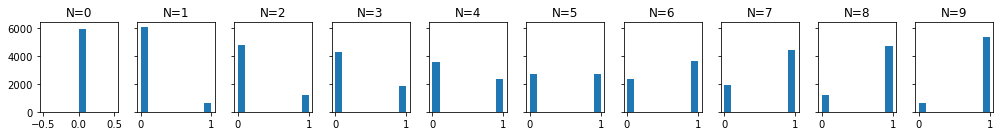

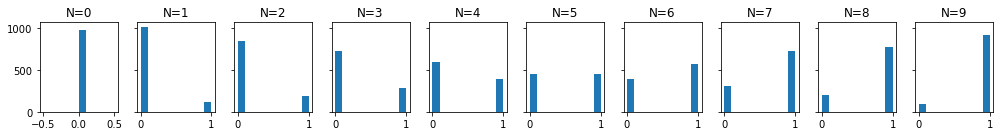

In [5]:
fig, ax = plt.subplots(1, 10, sharey=True, figsize=(14, 2))
for i in range(10):
    ax[i].hist(y_train[y_train_old == i])
    ax[i].set_title("N=" + str(i))
plt.tight_layout()

fig, ax = plt.subplots(1, 10, sharey=True, figsize=(14, 2))
for i in range(10):
    ax[i].hist(y_test[y_test_old == i])
    ax[i].set_title("N=" + str(i))
plt.tight_layout()

Lastly, we need to upsample the data to make it compatible with the default ResNets and check that they match the digits we printed earlier.

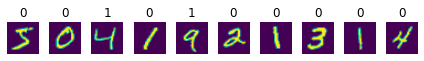

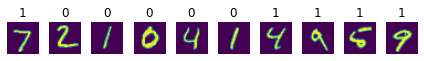

In [6]:
x_train_new = np.empty((len(x_train), 32, 32, 1))
for i, img in enumerate(x_train):
    x_train_new[i] = upsample(32, img).reshape(32, 32, 1)
    
x_test_new = np.empty((len(x_test), 32, 32, 1))
for i, img in enumerate(x_test):
    x_test_new[i] = upsample(32, img).reshape(32, 32, 1)
    
x_train, x_test = x_train_new, x_test_new
show_digits(x_train, y_train, range(10))
show_digits(x_test, y_test, range(10))

# Load the Model
We will load the smallest ResNet that tensorflow has on offer and then perform a quick test to show that we can transfer the weights from one to another. 

In [7]:
print(len(tf.keras.applications.ResNet101(include_top=False, weights=None).layers),
      len(tf.keras.applications.ResNet101V2(include_top=False, weights=None).layers),
      len(tf.keras.applications.ResNet152(include_top=False, weights=None).layers),
      len(tf.keras.applications.ResNet152V2(include_top=False, weights=None).layers),
      len(tf.keras.applications.ResNet50(include_top=False, weights=None).layers),
      len(tf.keras.applications.ResNet50V2(include_top=False, weights=None).layers))

345 377 515 564 175 190


In [19]:
model_name = "small_resnet_" + datetime.now().strftime("%m-%d-%Y_%H:%M:%S")
print("Model name:", model_name)
os.mkdir(model_name)
os.mkdir(model_name + "_new")
batch_size = 128
small_resnet = tf.keras.applications.ResNet50V2(
    include_top=False, weights=None, input_tensor=None,
    input_shape=(32, 32, 1), pooling='max', classes=1,
    classifier_activation='sigmoid')

Model name: small_resnet_05-21-2021_13:50:20


My understanding is that the V2 architectures generally outperform the V1 achitectures as they allow for gradients to propagate more freely to the block pointed to by the skip connection as they are not subjected to the block's activation before being added to it, so we will use `Resnet50V2`.

In [20]:
# class CustomCallback(keras.callbacks.Callback):
#     def __init__(self, name):
#         f = open(name + "/train.txt", "x")
#         f.close()
#         f = open(name + "/test.txt", "x")
#         f.close()
#         self.train_mse = []
#         self.test_mse = []
        
#     def on_batch_end(self, batch, logs=None):
#         p_train = self.model.predict(x_train[batch * batch_size : (batch + 1) * batch_size])
#         mse_train = mse(p_train, y_train_old[batch * batch_size : (batch + 1) * batch_size] / 10.)
#         self.train_mse.append(mse_train)
        
#     def on_epoch_end(self, epoch, logs=None):
#         p_test = self.model.predict(x_test)
#         mse_test = mse(p_test, y_test_old / 10.)
#         self.test_mse.append(mse_test)
        
#         mse_train = np.mean(self.train_mse)
#         self.train_mse = []

#         with open(model_name + "/train.txt", "a") as f:
#             f.write(str(mse_train) + " ")

#         with open(model_name + "/test.txt", "a") as f:
#             f.write(str(mse_test) + " ")
            
#         print("Epoch " + str(epoch) + " ending p* train MSE: " + str(mse_train))
#         print("Epoch " + str(epoch) + " ending p* test MSE: " + str(mse_test))

In [21]:
# Get model tops
top2 = keras.models.Sequential([
    keras.layers.Dense(256, activation='tanh', kernel_initializer=keras.initializers.RandomUniform()),
    keras.layers.Dense(128, activation='tanh', kernel_initializer=keras.initializers.RandomUniform()),
    keras.layers.Dense(1, activation='sigmoid', kernel_initializer=keras.initializers.RandomUniform())
], name='w_new')

top1 = keras.models.Sequential([
    keras.layers.Dense(256, activation='tanh', kernel_initializer=keras.initializers.RandomUniform()),
    keras.layers.Dense(128, activation='tanh', kernel_initializer=keras.initializers.RandomUniform()),
    keras.layers.Dense(1, activation='sigmoid', kernel_initializer=keras.initializers.RandomUniform())
], name='w_hat')


# opt = tfa.optimizers.SGDW(
#     weight_decay = 5e-4 * batch_size,
#     momentum = 0.9)

opt = keras.optimizers.SGD(momentum=0.9)

# Construct model
fhat_model = keras.Sequential()
fhat_model.add(small_resnet)
fhat_model.add(top1)
fhat_model.compile(optimizer=opt,
                   loss=keras.losses.BinaryCrossentropy(),
                   metrics=[keras.metrics.MeanSquaredError(), 
                            keras.metrics.BinaryAccuracy()])
fhat_model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Functional)      (None, 2048)              23558528  
_________________________________________________________________
w_hat (Sequential)           (None, 1)                 557569    
Total params: 24,116,097
Trainable params: 24,070,657
Non-trainable params: 45,440
_________________________________________________________________


Now that the model has been loaded, we will test two iterations of our training loop showing the MSE with p* after each iteration. To do this, we should (a) write a callback to compute the MSE for the fhat model and (b) do a test to make sure that the w_new * hhat model loads the correct weights from its two sources.

In [22]:
# Scheduler and opt taken from https://github.com/davidcpage/cifar10-fast/blob/master/experiments.ipynb
s = np.concatenate((np.linspace(0, 0.1, 16)[1:], np.linspace(0.1, 0.005, 16)[1:], np.linspace(0, 0.005, 7)[-1:1:-1]))
n = len(s)
def schedule_outer(epoch, lr):
    if i > n:
        return lr * 0.96
    else:
        return s[i]
lr_scheduler_outer = tf.keras.callbacks.LearningRateScheduler(schedule_outer, verbose=1)

def schedule_inner(epoch, lr):
    return lr * 0.96
lr_scheduler_inner = tf.keras.callbacks.LearningRateScheduler(schedule_inner, verbose=1)


n_epochs = 2
hists1 = []
hists2 = []

for i in range(n_epochs):
    fhat_model.trainable = True
    fhat_model.summary()
    hists1.append(fhat_model.fit(x=x_train, y=y_train, epochs=1, batch_size=batch_size, 
                                 validation_data=(x_test, y_test_old / 10.), shuffle=False,
                                 callbacks=[lr_scheduler_outer,]))

    model = keras.Sequential()
    model.add(fhat_model.layers[0])
    fhat_model.trainable = False
    model.add(top2)

    model.compile(optimizer=keras.optimizers.SGD(momentum=0.9),
                  loss=keras.losses.BinaryCrossentropy(),
                  metrics=[keras.metrics.MeanSquaredError()])
    model.summary()

    hists2.append(model.fit(x=x_train, y=y_train_old / 10., epochs=5, batch_size=batch_size, shuffle=False,
                            validation_data=(x_test, y_test_old / 10.), callbacks=[lr_scheduler_inner,]))

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Functional)      (None, 2048)              23558528  
_________________________________________________________________
w_hat (Sequential)           (None, 1)                 557569    
Total params: 24,116,097
Trainable params: 24,070,657
Non-trainable params: 45,440
_________________________________________________________________

Epoch 00001: LearningRateScheduler reducing learning rate to 0.006666666666666667.
469/469 [==============================] - 144s 303ms/step - loss: 0.6083 - mean_squared_error: 0.2119 - binary_accuracy: 0.6451 - val_loss: 0.5474 - val_mean_squared_error: 0.0214 - val_binary_accuracy: 0.0976
Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Functional)      (None, 2048)        

Merge hist1 and hist2 so we can see what's going on

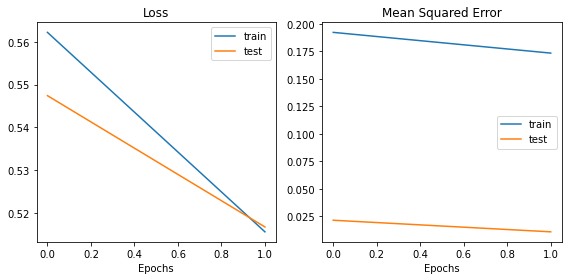

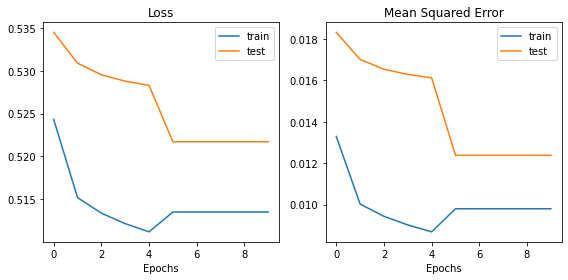

[0.7255363  0.05007176 0.09210654 ... 0.35326755 0.52741355 0.5531826 ]
0.015188293555786398
[0.6427675  0.0537303  0.106712   ... 0.49919918 0.50649357 0.4890999 ]
0.012382541388373877
0.07751189742453397
0.06795441972527189


In [37]:
total_hist1 = dict()
total_hist2 = dict()

for key in hists1[0].history.keys():
    current_values = [] 
    for hist_dict in hists1:
        hist_dict = hist_dict.history
        current_values += hist_dict[key]
    total_hist1[key] = current_values
    
for key in hists2[0].history.keys():
    current_values = [] 
    for hist_dict in hists2:
        hist_dict = hist_dict.history
        current_values += hist_dict[key]
    total_hist2[key] = current_values
    
fig, ax = plt.subplots(1, 2, figsize=(8,4))

ax[0].plot(total_hist1['loss'], label='train')
ax[0].plot(total_hist1['val_loss'], label='test')
ax[0].legend()
ax[0].set_title("Loss")
ax[0].set_xlabel("Epochs")


ax[1].plot(total_hist1['mean_squared_error'], label='train')
ax[1].plot(total_hist1['val_mean_squared_error'], label='test')
ax[1].legend()
ax[1].set_title("Mean Squared Error")
ax[1].set_xlabel("Epochs")

plt.tight_layout()
plt.show()

fig, ax = plt.subplots(1, 2, figsize=(8,4))

ax[0].plot(total_hist2['loss'], label='train')
ax[0].plot(total_hist2['val_loss'], label='test')
ax[0].legend()
ax[0].set_title("Loss")
ax[0].set_xlabel("Epochs")


ax[1].plot(total_hist2['mean_squared_error'], label='train')
ax[1].plot(total_hist2['val_mean_squared_error'], label='test')
ax[1].legend()
ax[1].set_title("Mean Squared Error")
ax[1].set_xlabel("Epochs")

plt.tight_layout()
plt.show()

print(mse(fhat_model.predict(x_test), y_test_old / 10.))
print(mse(model.predict(x_test), y_test_old / 10.))

print(mae(fhat_model.predict(x_test), y_test_old / 10.))
print(mae(model.predict(x_test), y_test_old / 10.))

Some observations:
- It appears that we're already overfitting in epoch 2 of the first global epoch of training--does this mean we should decrease the size of the two top layers? Try adding dropout to prevent overfitting? Although, this may not actually be overfitting because the ResNet uses regularization techniques that make training error not equal to evaluation error
- After the first round of global training, the MSE of the inner training loop stays fixed--I want to see if adding a ReduceLROnPlateau callback will help. Alternatively, we could try making the exponential decay larger.
- It looks like the modified outer learning rate scheduler is working great!
- Should we be resetting the top layer each time?

# New Model with ReduceLROnPlateau Callback
Analysis: resetting the new top helped a TON. ReducceLROnPlateau Callback doesn't do much, but will be useful when we train for longer periods of time. Overfitting is clearly still an issue though, so we will try dropout next.

Model name: small_resnet_05-21-2021_15:37:00
Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Functional)      (None, 2048)              23558528  
_________________________________________________________________
w_hat (Sequential)           (None, 1)                 557569    
Total params: 24,116,097
Trainable params: 24,070,657
Non-trainable params: 45,440
_________________________________________________________________
Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Functional)      (None, 2048)              23558528  
_________________________________________________________________
w_hat (Sequential)           (None, 1)                 557569    
Total params: 24,116,097
Trainable params: 24,070,657
Non-trainable params: 45,440
_________________

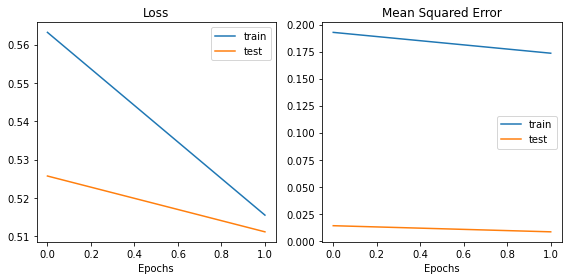

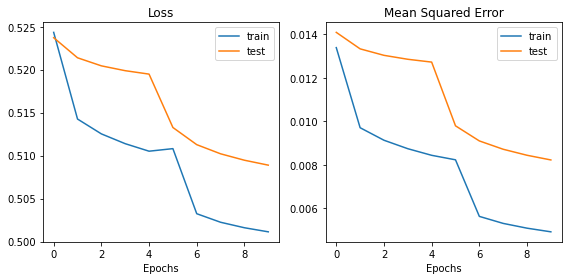

In [ ]:
# Model name and create resnet
model_name = "small_resnet_" + datetime.now().strftime("%m-%d-%Y_%H:%M:%S")
print("Model name:", model_name)
os.mkdir(model_name)
os.mkdir(model_name + "_new")
batch_size = 128
small_resnet = tf.keras.applications.ResNet50V2(
    include_top=False, weights=None, input_tensor=None,
    input_shape=(32, 32, 1), pooling='max', classes=1,
    classifier_activation='sigmoid')

top1 = keras.models.Sequential([
    keras.layers.Dense(256, activation='tanh', kernel_initializer=keras.initializers.RandomUniform()),
    keras.layers.Dense(128, activation='tanh', kernel_initializer=keras.initializers.RandomUniform()),
    keras.layers.Dense(1, activation='sigmoid', kernel_initializer=keras.initializers.RandomUniform())
], name='w_hat')

opt = keras.optimizers.SGD(momentum=0.9)

# Construct model
fhat_model = keras.Sequential()
fhat_model.add(small_resnet)
fhat_model.add(top1)
fhat_model.compile(optimizer=opt,
                   loss=keras.losses.BinaryCrossentropy(),
                   metrics=[keras.metrics.MeanSquaredError(), 
                            keras.metrics.BinaryAccuracy()])
fhat_model.summary()


# Scheduler taken from https://github.com/davidcpage/cifar10-fast/blob/master/experiments.ipynb
s = np.concatenate((np.linspace(0, 0.1, 16)[1:], np.linspace(0.1, 0.005, 16)[1:], np.linspace(0, 0.005, 7)[-1:1:-1]))
n = len(s)
def schedule_outer(epoch, lr):
    if i > n:
        return lr * 0.96
    else:
        return s[i]
lr_scheduler_outer = tf.keras.callbacks.LearningRateScheduler(schedule_outer, verbose=1)

def schedule_inner(epoch, lr):
    return lr * 0.96
lr_scheduler_inner = tf.keras.callbacks.LearningRateScheduler(schedule_inner, verbose=1)


lr_reduce = keras.callbacks.ReduceLROnPlateau(
    monitor='val_mean_squared_error', factor=0.1, patience=1, verbose=1,
    mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)


n_epochs = 2
hists1 = []
hists2 = []

for i in range(n_epochs):
    fhat_model.trainable = True
    fhat_model.summary()
    hists1.append(fhat_model.fit(x=x_train, y=y_train, epochs=1, batch_size=batch_size, 
                                 validation_data=(x_test, y_test_old / 10.), shuffle=False,
                                 callbacks=[lr_scheduler_outer,]))

    model = keras.Sequential()
    model.add(fhat_model.layers[0])
    fhat_model.trainable = False
    
    top2 = keras.models.Sequential([
            keras.layers.Dense(256, activation='tanh', kernel_initializer=keras.initializers.RandomUniform()),
            keras.layers.Dense(128, activation='tanh', kernel_initializer=keras.initializers.RandomUniform()),
            keras.layers.Dense(1, activation='sigmoid', kernel_initializer=keras.initializers.RandomUniform())
        ], name='w_new')
    
    model.add(top2)

    model.compile(optimizer=keras.optimizers.SGD(momentum=0.9),
                  loss=keras.losses.BinaryCrossentropy(),
                  metrics=[keras.metrics.MeanSquaredError()])
    model.summary()

    hists2.append(model.fit(x=x_train, y=y_train_old / 10., epochs=5, batch_size=batch_size, shuffle=False,
                            validation_data=(x_test, y_test_old / 10.), callbacks=[lr_scheduler_inner, lr_reduce,]))

total_hist1 = dict()
total_hist2 = dict()

for key in hists1[0].history.keys():
    current_values = [] 
    for hist_dict in hists1:
        hist_dict = hist_dict.history
        current_values += hist_dict[key]
    total_hist1[key] = current_values
    
for key in hists2[0].history.keys():
    current_values = [] 
    for hist_dict in hists2:
        hist_dict = hist_dict.history
        current_values += hist_dict[key]
    total_hist2[key] = current_values
    
fig, ax = plt.subplots(1, 2, figsize=(8,4))

ax[0].plot(total_hist1['loss'], label='train')
ax[0].plot(total_hist1['val_loss'], label='test')
ax[0].legend()
ax[0].set_title("Loss")
ax[0].set_xlabel("Epochs")


ax[1].plot(total_hist1['mean_squared_error'], label='train')
ax[1].plot(total_hist1['val_mean_squared_error'], label='test')
ax[1].legend()
ax[1].set_title("Mean Squared Error")
ax[1].set_xlabel("Epochs")

plt.tight_layout()
plt.show()

fig, ax = plt.subplots(1, 2, figsize=(8,4))

ax[0].plot(total_hist2['loss'], label='train')
ax[0].plot(total_hist2['val_loss'], label='test')
ax[0].legend()
ax[0].set_title("Loss")
ax[0].set_xlabel("Epochs")


ax[1].plot(total_hist2['mean_squared_error'], label='train')
ax[1].plot(total_hist2['val_mean_squared_error'], label='test')
ax[1].legend()
ax[1].set_title("Mean Squared Error")
ax[1].set_xlabel("Epochs")

plt.tight_layout()
plt.show()

print(mse(fhat_model.predict(x_test), y_test_old / 10.))
print(mse(model.predict(x_test), y_test_old / 10.))

print(mae(fhat_model.predict(x_test), y_test_old / 10.))
print(mae(model.predict(x_test), y_test_old / 10.))

# Try L2 regularization (to reduce overfitting)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Functional)      (None, 2048)              23558528  
_________________________________________________________________
w_hat (Sequential)           (None, 1)                 557569    
Total params: 24,116,097
Trainable params: 24,070,657
Non-trainable params: 45,440
_________________________________________________________________
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Functional)      (None, 2048)              23558528  
_________________________________________________________________
w_hat (Sequential)           (None, 1)                 557569    
Total params: 24,116,097
Trainable params: 24,070,657
Non-trainable params: 45,440
_________________________________________________________________

E

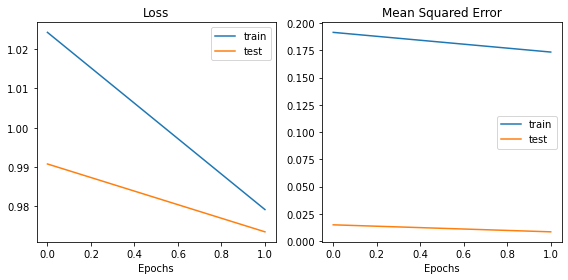

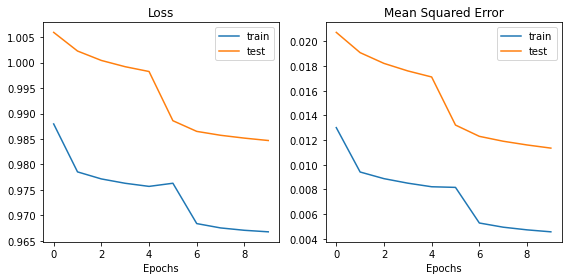

0.013451509622448461
0.01135015826353481
0.07111631840646268
0.061415813623620204


In [7]:
# Model name and create resnet
# model_name = "small_resnet_" + datetime.now().strftime("%m-%d-%Y_%H:%M:%S")
# print("Model name:", model_name)
# os.mkdir(model_name)
# os.mkdir(model_name + "_new")
batch_size = 128
small_resnet = tf.keras.applications.ResNet50V2(
    include_top=False, weights=None, input_tensor=None,
    input_shape=(32, 32, 1), pooling='max', classes=1,
    classifier_activation='sigmoid')

top1 = keras.models.Sequential([
    keras.layers.Dense(256, activation='tanh', 
                       kernel_initializer=keras.initializers.RandomUniform(), 
                       kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dense(128, activation='tanh', 
                       kernel_initializer=keras.initializers.RandomUniform(), 
                       kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dense(1, activation='sigmoid', 
                       kernel_initializer=keras.initializers.RandomUniform(), 
                       kernel_regularizer=keras.regularizers.l2(0.001))
], name='w_hat')

opt = keras.optimizers.SGD(momentum=0.9)

# Construct model
fhat_model = keras.Sequential()
fhat_model.add(small_resnet)
fhat_model.add(top1)
fhat_model.compile(optimizer=opt,
                   loss=keras.losses.BinaryCrossentropy(),
                   metrics=[keras.metrics.MeanSquaredError(), 
                            keras.metrics.BinaryAccuracy()])
fhat_model.summary()


# Scheduler taken from https://github.com/davidcpage/cifar10-fast/blob/master/experiments.ipynb
s = np.concatenate((np.linspace(0, 0.1, 16)[1:], np.linspace(0.1, 0.005, 16)[1:], np.linspace(0, 0.005, 7)[-1:1:-1]))
n = len(s)
def schedule_outer(epoch, lr):
    if i > n:
        return lr * 0.96
    else:
        return s[i]
lr_scheduler_outer = tf.keras.callbacks.LearningRateScheduler(schedule_outer, verbose=1)

def schedule_inner(epoch, lr):
    return lr * 0.96
lr_scheduler_inner = tf.keras.callbacks.LearningRateScheduler(schedule_inner, verbose=1)


lr_reduce = keras.callbacks.ReduceLROnPlateau(
    monitor='val_mean_squared_error', factor=0.1, patience=1, verbose=1,
    mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)


n_epochs = 2
hists1 = []
hists2 = []

for i in range(n_epochs):
    fhat_model.trainable = True
    fhat_model.summary()
    hists1.append(fhat_model.fit(x=x_train, y=y_train, epochs=1, batch_size=batch_size, 
                                 validation_data=(x_test, y_test_old / 10.), shuffle=False,
                                 callbacks=[lr_scheduler_outer,]))

    model = keras.Sequential()
    model.add(fhat_model.layers[0])
    fhat_model.trainable = False
    
    top2 = keras.models.Sequential([
        keras.layers.Dense(256, activation='tanh', 
                           kernel_initializer=keras.initializers.RandomUniform(), 
                           kernel_regularizer=keras.regularizers.l2(0.001)),
        keras.layers.Dense(128, activation='tanh', 
                           kernel_initializer=keras.initializers.RandomUniform(), 
                           kernel_regularizer=keras.regularizers.l2(0.001)),
        keras.layers.Dense(1, activation='sigmoid', 
                           kernel_initializer=keras.initializers.RandomUniform(), 
                           kernel_regularizer=keras.regularizers.l2(0.001))
    ], name='w_hat')
    
    model.add(top2)

    model.compile(optimizer=keras.optimizers.SGD(momentum=0.9),
                  loss=keras.losses.BinaryCrossentropy(),
                  metrics=[keras.metrics.MeanSquaredError()])
    model.summary()

    hists2.append(model.fit(x=x_train, y=y_train_old / 10., epochs=5, batch_size=batch_size, shuffle=False,
                            validation_data=(x_test, y_test_old / 10.), callbacks=[lr_scheduler_inner, lr_reduce,]))

total_hist1 = dict()
total_hist2 = dict()

for key in hists1[0].history.keys():
    current_values = [] 
    for hist_dict in hists1:
        hist_dict = hist_dict.history
        current_values += hist_dict[key]
    total_hist1[key] = current_values
    
for key in hists2[0].history.keys():
    current_values = [] 
    for hist_dict in hists2:
        hist_dict = hist_dict.history
        current_values += hist_dict[key]
    total_hist2[key] = current_values
    
fig, ax = plt.subplots(1, 2, figsize=(8,4))

ax[0].plot(total_hist1['loss'], label='train')
ax[0].plot(total_hist1['val_loss'], label='test')
ax[0].legend()
ax[0].set_title("Loss")
ax[0].set_xlabel("Epochs")


ax[1].plot(total_hist1['mean_squared_error'], label='train')
ax[1].plot(total_hist1['val_mean_squared_error'], label='test')
ax[1].legend()
ax[1].set_title("Mean Squared Error")
ax[1].set_xlabel("Epochs")

plt.tight_layout()
plt.show()

fig, ax = plt.subplots(1, 2, figsize=(8,4))

ax[0].plot(total_hist2['loss'], label='train')
ax[0].plot(total_hist2['val_loss'], label='test')
ax[0].legend()
ax[0].set_title("Loss")
ax[0].set_xlabel("Epochs")


ax[1].plot(total_hist2['mean_squared_error'], label='train')
ax[1].plot(total_hist2['val_mean_squared_error'], label='test')
ax[1].legend()
ax[1].set_title("Mean Squared Error")
ax[1].set_xlabel("Epochs")

plt.tight_layout()
plt.show()

print(mse(fhat_model.predict(x_test), y_test_old / 10.))
print(mse(model.predict(x_test), y_test_old / 10.))

print(mae(fhat_model.predict(x_test), y_test_old / 10.))
print(mae(model.predict(x_test), y_test_old / 10.))

# Add Dropout

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Functional)      (None, 2048)              23558528  
_________________________________________________________________
w_hat (Sequential)           (None, 1)                 557569    
Total params: 24,116,097
Trainable params: 24,070,657
Non-trainable params: 45,440
_________________________________________________________________
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Functional)      (None, 2048)              23558528  
_________________________________________________________________
w_hat (Sequential)           (None, 1)                 557569    
Total params: 24,116,097
Trainable params: 24,070,657
Non-trainable params: 45,440
________________________________________________________________

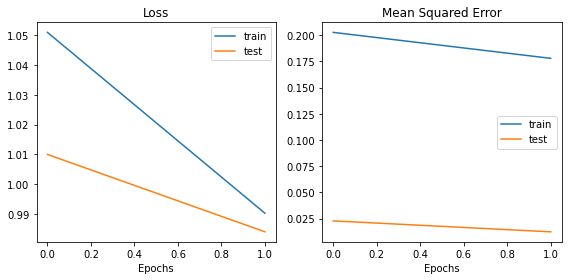

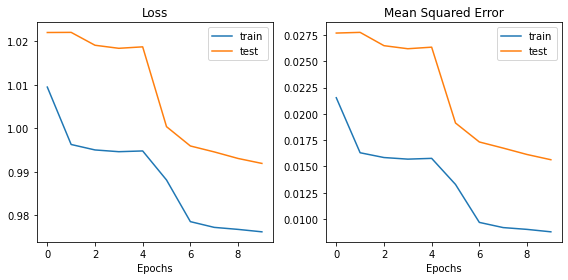

0.0178179245221316
0.015640554061853135
0.0857768898832053
0.08001011188706383


In [8]:
# Model name and create resnet
# model_name = "small_resnet_" + datetime.now().strftime("%m-%d-%Y_%H:%M:%S")
# print("Model name:", model_name)
# os.mkdir(model_name)
# os.mkdir(model_name + "_new")
batch_size = 128
small_resnet = tf.keras.applications.ResNet50V2(
    include_top=False, weights=None, input_tensor=None,
    input_shape=(32, 32, 1), pooling='max', classes=1,
    classifier_activation='sigmoid')

top1 = keras.models.Sequential([
    keras.layers.Dense(256, activation='tanh', 
                       kernel_initializer=keras.initializers.RandomUniform(), 
                       kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(128, activation='tanh', 
                       kernel_initializer=keras.initializers.RandomUniform(), 
                       kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1, activation='sigmoid', 
                       kernel_initializer=keras.initializers.RandomUniform(), 
                       kernel_regularizer=keras.regularizers.l2(0.001))
], name='w_hat')

opt = keras.optimizers.SGD(momentum=0.9)

# Construct model
fhat_model = keras.Sequential()
fhat_model.add(small_resnet)
fhat_model.add(top1)
fhat_model.compile(optimizer=opt,
                   loss=keras.losses.BinaryCrossentropy(),
                   metrics=[keras.metrics.MeanSquaredError(), 
                            keras.metrics.BinaryAccuracy()])
fhat_model.summary()


# Scheduler taken from https://github.com/davidcpage/cifar10-fast/blob/master/experiments.ipynb
s = np.concatenate((np.linspace(0, 0.1, 16)[1:], np.linspace(0.1, 0.005, 16)[1:], np.linspace(0, 0.005, 7)[-1:1:-1]))
n = len(s)
def schedule_outer(epoch, lr):
    if i > n:
        return lr * 0.96
    else:
        return s[i]
lr_scheduler_outer = tf.keras.callbacks.LearningRateScheduler(schedule_outer, verbose=1)

def schedule_inner(epoch, lr):
    return lr * 0.96
lr_scheduler_inner = tf.keras.callbacks.LearningRateScheduler(schedule_inner, verbose=1)


lr_reduce = keras.callbacks.ReduceLROnPlateau(
    monitor='val_mean_squared_error', factor=0.1, patience=1, verbose=1,
    mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)


n_epochs = 2
hists1 = []
hists2 = []

for i in range(n_epochs):
    fhat_model.trainable = True
    fhat_model.summary()
    hists1.append(fhat_model.fit(x=x_train, y=y_train, epochs=1, batch_size=batch_size, 
                                 validation_data=(x_test, y_test_old / 10.), shuffle=False,
                                 callbacks=[lr_scheduler_outer,]))

    model = keras.Sequential()
    model.add(fhat_model.layers[0])
    fhat_model.trainable = False
    
    top2 = keras.models.Sequential([
        keras.layers.Dense(256, activation='tanh', 
                           kernel_initializer=keras.initializers.RandomUniform(), 
                           kernel_regularizer=keras.regularizers.l2(0.001)),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(128, activation='tanh', 
                           kernel_initializer=keras.initializers.RandomUniform(), 
                           kernel_regularizer=keras.regularizers.l2(0.001)),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(1, activation='sigmoid', 
                           kernel_initializer=keras.initializers.RandomUniform(), 
                           kernel_regularizer=keras.regularizers.l2(0.001))
    ], name='w_hat')
    
    model.add(top2)

    model.compile(optimizer=keras.optimizers.SGD(momentum=0.9),
                  loss=keras.losses.BinaryCrossentropy(),
                  metrics=[keras.metrics.MeanSquaredError()])
    model.summary()

    hists2.append(model.fit(x=x_train, y=y_train_old / 10., epochs=5, batch_size=batch_size, shuffle=False,
                            validation_data=(x_test, y_test_old / 10.), callbacks=[lr_scheduler_inner, lr_reduce,]))

total_hist1 = dict()
total_hist2 = dict()

for key in hists1[0].history.keys():
    current_values = [] 
    for hist_dict in hists1:
        hist_dict = hist_dict.history
        current_values += hist_dict[key]
    total_hist1[key] = current_values
    
for key in hists2[0].history.keys():
    current_values = [] 
    for hist_dict in hists2:
        hist_dict = hist_dict.history
        current_values += hist_dict[key]
    total_hist2[key] = current_values
    
fig, ax = plt.subplots(1, 2, figsize=(8,4))

ax[0].plot(total_hist1['loss'], label='train')
ax[0].plot(total_hist1['val_loss'], label='test')
ax[0].legend()
ax[0].set_title("Loss")
ax[0].set_xlabel("Epochs")


ax[1].plot(total_hist1['mean_squared_error'], label='train')
ax[1].plot(total_hist1['val_mean_squared_error'], label='test')
ax[1].legend()
ax[1].set_title("Mean Squared Error")
ax[1].set_xlabel("Epochs")

plt.tight_layout()
plt.show()

fig, ax = plt.subplots(1, 2, figsize=(8,4))

ax[0].plot(total_hist2['loss'], label='train')
ax[0].plot(total_hist2['val_loss'], label='test')
ax[0].legend()
ax[0].set_title("Loss")
ax[0].set_xlabel("Epochs")


ax[1].plot(total_hist2['mean_squared_error'], label='train')
ax[1].plot(total_hist2['val_mean_squared_error'], label='test')
ax[1].legend()
ax[1].set_title("Mean Squared Error")
ax[1].set_xlabel("Epochs")

plt.tight_layout()
plt.show()

print(mse(fhat_model.predict(x_test), y_test_old / 10.))
print(mse(model.predict(x_test), y_test_old / 10.))

print(mae(fhat_model.predict(x_test), y_test_old / 10.))
print(mae(model.predict(x_test), y_test_old / 10.))

# New Model with Fewer Neurons in Dense Layers

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Functional)      (None, 2048)              23558528  
_________________________________________________________________
w_hat (Sequential)           (None, 1)                 270593    
Total params: 23,829,121
Trainable params: 23,783,681
Non-trainable params: 45,440
_________________________________________________________________
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Functional)      (None, 2048)              23558528  
_________________________________________________________________
w_hat (Sequential)           (None, 1)                 270593    
Total params: 23,829,121
Trainable params: 23,783,681
Non-trainable params: 45,440
________________________________________________________________

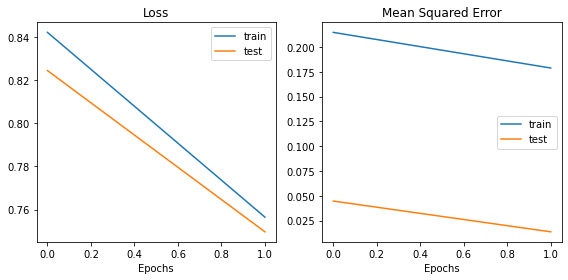

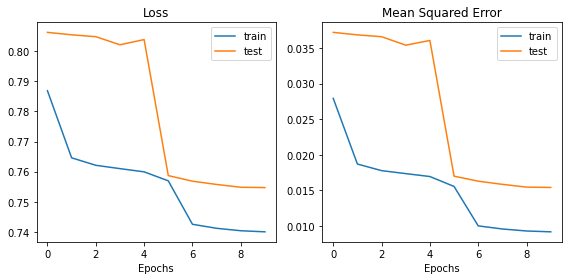

0.02128582303141144
0.015411280682089091
0.09804846748948097
0.08045646744066848


In [9]:
# Model name and create resnet
# model_name = "small_resnet_" + datetime.now().strftime("%m-%d-%Y_%H:%M:%S")
# print("Model name:", model_name)
# os.mkdir(model_name)
# os.mkdir(model_name + "_new")
batch_size = 128
small_resnet = tf.keras.applications.ResNet50V2(
    include_top=False, weights=None, input_tensor=None,
    input_shape=(32, 32, 1), pooling='max', classes=1,
    classifier_activation='sigmoid')

top1 = keras.models.Sequential([
    keras.layers.Dense(128, activation='tanh', 
                       kernel_initializer=keras.initializers.RandomUniform(), 
                       kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(64, activation='tanh', 
                       kernel_initializer=keras.initializers.RandomUniform(), 
                       kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1, activation='sigmoid', 
                       kernel_initializer=keras.initializers.RandomUniform(), 
                       kernel_regularizer=keras.regularizers.l2(0.001))
], name='w_hat')

opt = keras.optimizers.SGD(momentum=0.9)

# Construct model
fhat_model = keras.Sequential()
fhat_model.add(small_resnet)
fhat_model.add(top1)
fhat_model.compile(optimizer=opt,
                   loss=keras.losses.BinaryCrossentropy(),
                   metrics=[keras.metrics.MeanSquaredError(), 
                            keras.metrics.BinaryAccuracy()])
fhat_model.summary()


# Scheduler taken from https://github.com/davidcpage/cifar10-fast/blob/master/experiments.ipynb
s = np.concatenate((np.linspace(0, 0.1, 16)[1:], np.linspace(0.1, 0.005, 16)[1:], np.linspace(0, 0.005, 7)[-1:1:-1]))
n = len(s)
def schedule_outer(epoch, lr):
    if i > n:
        return lr * 0.96
    else:
        return s[i]
lr_scheduler_outer = tf.keras.callbacks.LearningRateScheduler(schedule_outer, verbose=1)

def schedule_inner(epoch, lr):
    return lr * 0.96
lr_scheduler_inner = tf.keras.callbacks.LearningRateScheduler(schedule_inner, verbose=1)


lr_reduce = keras.callbacks.ReduceLROnPlateau(
    monitor='val_mean_squared_error', factor=0.1, patience=1, verbose=1,
    mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)


n_epochs = 2
hists1 = []
hists2 = []

for i in range(n_epochs):
    fhat_model.trainable = True
    fhat_model.summary()
    hists1.append(fhat_model.fit(x=x_train, y=y_train, epochs=1, batch_size=batch_size, 
                                 validation_data=(x_test, y_test_old / 10.), shuffle=False,
                                 callbacks=[lr_scheduler_outer,]))

    model = keras.Sequential()
    model.add(fhat_model.layers[0])
    fhat_model.trainable = False
    
    top2 = keras.models.Sequential([
        keras.layers.Dense(128, activation='tanh', 
                           kernel_initializer=keras.initializers.RandomUniform(), 
                           kernel_regularizer=keras.regularizers.l2(0.001)),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(64, activation='tanh', 
                           kernel_initializer=keras.initializers.RandomUniform(), 
                           kernel_regularizer=keras.regularizers.l2(0.001)),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(1, activation='sigmoid', 
                           kernel_initializer=keras.initializers.RandomUniform(), 
                           kernel_regularizer=keras.regularizers.l2(0.001))
    ], name='w_hat')
    
    model.add(top2)

    model.compile(optimizer=keras.optimizers.SGD(momentum=0.9),
                  loss=keras.losses.BinaryCrossentropy(),
                  metrics=[keras.metrics.MeanSquaredError()])
    model.summary()

    hists2.append(model.fit(x=x_train, y=y_train_old / 10., epochs=5, batch_size=batch_size, shuffle=False,
                            validation_data=(x_test, y_test_old / 10.), callbacks=[lr_scheduler_inner, lr_reduce,]))

total_hist1 = dict()
total_hist2 = dict()

for key in hists1[0].history.keys():
    current_values = [] 
    for hist_dict in hists1:
        hist_dict = hist_dict.history
        current_values += hist_dict[key]
    total_hist1[key] = current_values
    
for key in hists2[0].history.keys():
    current_values = [] 
    for hist_dict in hists2:
        hist_dict = hist_dict.history
        current_values += hist_dict[key]
    total_hist2[key] = current_values
    
fig, ax = plt.subplots(1, 2, figsize=(8,4))

ax[0].plot(total_hist1['loss'], label='train')
ax[0].plot(total_hist1['val_loss'], label='test')
ax[0].legend()
ax[0].set_title("Loss")
ax[0].set_xlabel("Epochs")


ax[1].plot(total_hist1['mean_squared_error'], label='train')
ax[1].plot(total_hist1['val_mean_squared_error'], label='test')
ax[1].legend()
ax[1].set_title("Mean Squared Error")
ax[1].set_xlabel("Epochs")

plt.tight_layout()
plt.show()

fig, ax = plt.subplots(1, 2, figsize=(8,4))

ax[0].plot(total_hist2['loss'], label='train')
ax[0].plot(total_hist2['val_loss'], label='test')
ax[0].legend()
ax[0].set_title("Loss")
ax[0].set_xlabel("Epochs")


ax[1].plot(total_hist2['mean_squared_error'], label='train')
ax[1].plot(total_hist2['val_mean_squared_error'], label='test')
ax[1].legend()
ax[1].set_title("Mean Squared Error")
ax[1].set_xlabel("Epochs")

plt.tight_layout()
plt.show()

print(mse(fhat_model.predict(x_test), y_test_old / 10.))
print(mse(model.predict(x_test), y_test_old / 10.))

print(mae(fhat_model.predict(x_test), y_test_old / 10.))
print(mae(model.predict(x_test), y_test_old / 10.))

# Run a 10 Epoch Test
We will run a similar test to optimize regularization, number of neurons, and dropout on the cluster, but we will run a quick test to make sure everything else works here too.

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Functional)      (None, 2048)              23558528  
_________________________________________________________________
w_hat (Sequential)           (None, 1)                 270593    
Total params: 23,829,121
Trainable params: 23,783,681
Non-trainable params: 45,440
_________________________________________________________________
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Functional)      (None, 2048)              23558528  
_________________________________________________________________
w_hat (Sequential)           (None, 1)                 270593    
Total params: 23,829,121
Trainable params: 23,783,681
Non-trainable params: 45,440
________________________________________________________________

469/469 [==============================] - 53s 112ms/step - loss: 0.7822 - mean_squared_error: 0.0267 - val_loss: 0.7642 - val_mean_squared_error: 0.0199
Epoch 2/5

Epoch 00002: LearningRateScheduler reducing learning rate to 0.00921599954366684.
469/469 [==============================] - 52s 111ms/step - loss: 0.7354 - mean_squared_error: 0.0078 - val_loss: 0.7599 - val_mean_squared_error: 0.0183
Epoch 3/5

Epoch 00003: LearningRateScheduler reducing learning rate to 0.008847359418869018.
469/469 [==============================] - 52s 111ms/step - loss: 0.7339 - mean_squared_error: 0.0073 - val_loss: 0.7592 - val_mean_squared_error: 0.0180
Epoch 4/5

Epoch 00004: LearningRateScheduler reducing learning rate to 0.008493465185165404.
469/469 [==============================] - 52s 111ms/step - loss: 0.7332 - mean_squared_error: 0.0070 - val_loss: 0.7568 - val_mean_squared_error: 0.0170
Epoch 5/5

Epoch 00005: LearningRateScheduler reducing learning rate to 0.008153726756572723.
469/469 [

Epoch 1/5

Epoch 00001: LearningRateScheduler reducing learning rate to 0.009599999785423278.
469/469 [==============================] - 54s 112ms/step - loss: 0.7758 - mean_squared_error: 0.0236 - val_loss: 0.7654 - val_mean_squared_error: 0.0206
Epoch 2/5

Epoch 00002: LearningRateScheduler reducing learning rate to 0.00921599954366684.
469/469 [==============================] - 54s 115ms/step - loss: 0.7340 - mean_squared_error: 0.0070 - val_loss: 0.7600 - val_mean_squared_error: 0.0185
Epoch 3/5

Epoch 00003: LearningRateScheduler reducing learning rate to 0.008847359418869018.
469/469 [==============================] - 55s 117ms/step - loss: 0.7327 - mean_squared_error: 0.0066 - val_loss: 0.7574 - val_mean_squared_error: 0.0174
Epoch 4/5

Epoch 00004: LearningRateScheduler reducing learning rate to 0.008493465185165404.
469/469 [==============================] - 53s 114ms/step - loss: 0.7320 - mean_squared_error: 0.0063 - val_loss: 0.7552 - val_mean_squared_error: 0.0165
Epoch 5/5

Epoch 1/5

Epoch 00001: LearningRateScheduler reducing learning rate to 0.009599999785423278.
469/469 [==============================] - 54s 113ms/step - loss: 0.7795 - mean_squared_error: 0.0253 - val_loss: 0.7656 - val_mean_squared_error: 0.0212
Epoch 2/5

Epoch 00002: LearningRateScheduler reducing learning rate to 0.00921599954366684.
469/469 [==============================] - 52s 112ms/step - loss: 0.7354 - mean_squared_error: 0.0077 - val_loss: 0.7619 - val_mean_squared_error: 0.0196
Epoch 3/5

Epoch 00003: LearningRateScheduler reducing learning rate to 0.008847359418869018.
469/469 [==============================] - 53s 112ms/step - loss: 0.7338 - mean_squared_error: 0.0071 - val_loss: 0.7608 - val_mean_squared_error: 0.0191
Epoch 4/5

Epoch 00004: LearningRateScheduler reducing learning rate to 0.008493465185165404.
469/469 [==============================] - 54s 115ms/step - loss: 0.7329 - mean_squared_error: 0.0068 - val_loss: 0.7626 - val_mean_squared_error: 0.0198

Epoch 00

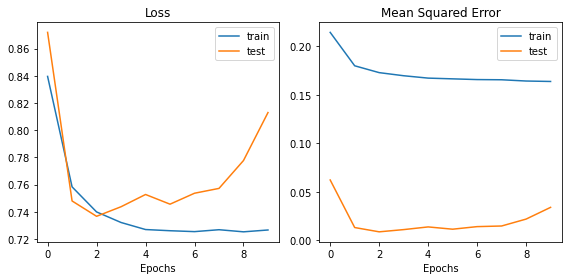

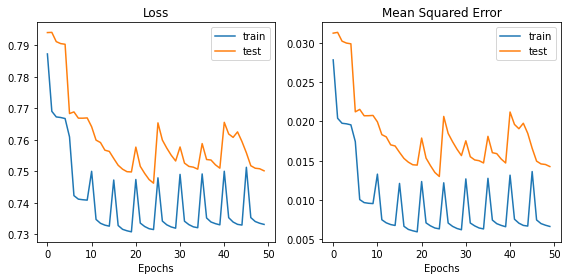

0.02992621427626019
0.014264640494836453
0.10937449763568118
0.07365174808915703


In [10]:
# Model name and create resnet
# model_name = "small_resnet_" + datetime.now().strftime("%m-%d-%Y_%H:%M:%S")
# print("Model name:", model_name)
# os.mkdir(model_name)
# os.mkdir(model_name + "_new")
batch_size = 128
small_resnet = tf.keras.applications.ResNet50V2(
    include_top=False, weights=None, input_tensor=None,
    input_shape=(32, 32, 1), pooling='max', classes=1,
    classifier_activation='sigmoid')

top1 = keras.models.Sequential([
    keras.layers.Dense(128, activation='tanh', 
                       kernel_initializer=keras.initializers.RandomUniform(), 
                       kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(64, activation='tanh', 
                       kernel_initializer=keras.initializers.RandomUniform(), 
                       kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1, activation='sigmoid', 
                       kernel_initializer=keras.initializers.RandomUniform(), 
                       kernel_regularizer=keras.regularizers.l2(0.001))
], name='w_hat')

opt = keras.optimizers.SGD(momentum=0.9)

# Construct model
fhat_model = keras.Sequential()
fhat_model.add(small_resnet)
fhat_model.add(top1)
fhat_model.compile(optimizer=opt,
                   loss=keras.losses.BinaryCrossentropy(),
                   metrics=[keras.metrics.MeanSquaredError(), 
                            keras.metrics.BinaryAccuracy()])
fhat_model.summary()


# Scheduler taken from https://github.com/davidcpage/cifar10-fast/blob/master/experiments.ipynb
s = np.concatenate((np.linspace(0, 0.1, 16)[1:], np.linspace(0.1, 0.005, 16)[1:], np.linspace(0, 0.005, 7)[-1:1:-1]))
n = len(s)
def schedule_outer(epoch, lr):
    if i > n:
        return lr * 0.96
    else:
        return s[i]
lr_scheduler_outer = tf.keras.callbacks.LearningRateScheduler(schedule_outer, verbose=1)

def schedule_inner(epoch, lr):
    return lr * 0.96
lr_scheduler_inner = tf.keras.callbacks.LearningRateScheduler(schedule_inner, verbose=1)


lr_reduce = keras.callbacks.ReduceLROnPlateau(
    monitor='val_mean_squared_error', factor=0.1, patience=1, verbose=1,
    mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)


n_epochs = 10
hists1 = []
hists2 = []

for i in range(n_epochs):
    fhat_model.trainable = True
    fhat_model.summary()
    hists1.append(fhat_model.fit(x=x_train, y=y_train, epochs=1, batch_size=batch_size, 
                                 validation_data=(x_test, y_test_old / 10.), shuffle=False,
                                 callbacks=[lr_scheduler_outer,]))

    model = keras.Sequential()
    model.add(fhat_model.layers[0])
    fhat_model.trainable = False
    
    top2 = keras.models.Sequential([
        keras.layers.Dense(128, activation='tanh', 
                           kernel_initializer=keras.initializers.RandomUniform(), 
                           kernel_regularizer=keras.regularizers.l2(0.001)),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(64, activation='tanh', 
                           kernel_initializer=keras.initializers.RandomUniform(), 
                           kernel_regularizer=keras.regularizers.l2(0.001)),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(1, activation='sigmoid', 
                           kernel_initializer=keras.initializers.RandomUniform(), 
                           kernel_regularizer=keras.regularizers.l2(0.001))
    ], name='w_hat')
    
    model.add(top2)

    model.compile(optimizer=keras.optimizers.SGD(momentum=0.9),
                  loss=keras.losses.BinaryCrossentropy(),
                  metrics=[keras.metrics.MeanSquaredError()])
    model.summary()

    hists2.append(model.fit(x=x_train, y=y_train_old / 10., epochs=5, batch_size=batch_size, shuffle=False,
                            validation_data=(x_test, y_test_old / 10.), callbacks=[lr_scheduler_inner, lr_reduce,]))

total_hist1 = dict()
total_hist2 = dict()

for key in hists1[0].history.keys():
    current_values = [] 
    for hist_dict in hists1:
        hist_dict = hist_dict.history
        current_values += hist_dict[key]
    total_hist1[key] = current_values
    
for key in hists2[0].history.keys():
    current_values = [] 
    for hist_dict in hists2:
        hist_dict = hist_dict.history
        current_values += hist_dict[key]
    total_hist2[key] = current_values
    
fig, ax = plt.subplots(1, 2, figsize=(8,4))

ax[0].plot(total_hist1['loss'], label='train')
ax[0].plot(total_hist1['val_loss'], label='test')
ax[0].legend()
ax[0].set_title("Loss")
ax[0].set_xlabel("Epochs")


ax[1].plot(total_hist1['mean_squared_error'], label='train')
ax[1].plot(total_hist1['val_mean_squared_error'], label='test')
ax[1].legend()
ax[1].set_title("Mean Squared Error")
ax[1].set_xlabel("Epochs")

plt.tight_layout()
plt.show()

fig, ax = plt.subplots(1, 2, figsize=(8,4))

ax[0].plot(total_hist2['loss'], label='train')
ax[0].plot(total_hist2['val_loss'], label='test')
ax[0].legend()
ax[0].set_title("Loss")
ax[0].set_xlabel("Epochs")


ax[1].plot(total_hist2['mean_squared_error'], label='train')
ax[1].plot(total_hist2['val_mean_squared_error'], label='test')
ax[1].legend()
ax[1].set_title("Mean Squared Error")
ax[1].set_xlabel("Epochs")

plt.tight_layout()
plt.show()

print(mse(fhat_model.predict(x_test), y_test_old / 10.))
print(mse(model.predict(x_test), y_test_old / 10.))

print(mae(fhat_model.predict(x_test), y_test_old / 10.))
print(mae(model.predict(x_test), y_test_old / 10.))

# Last Test Before the Cluster
Before moving to the cluster, we should update to model checkpointing AND add multiple validation sets so we can actually compare what we want to compare. We will just test this for a couple epochs to make sure it works.

Time: 05-22-2021_12:56:14
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Functional)      (None, 2048)              23558528  
_________________________________________________________________
w_hat (Sequential)           (None, 1)                 270593    
Total params: 23,829,121
Trainable params: 23,783,681
Non-trainable params: 45,440
_________________________________________________________________

Epoch 00001: LearningRateScheduler reducing learning rate to 0.006666666666666667.
469/469 [==============================] - 137s 288ms/step - loss: 0.8763 - mean_squared_error: 0.2307 - binary_accuracy: 0.5964 - val_loss: 0.7714 - val_mean_squared_error: 0.1851 - val_binary_accuracy: 0.7092

Epoch 00001: val_mean_squared_error improved from inf to 0.18511, saving model to fhat_05-22-2021_12:56:14

FOR DEVS: If you are overwriting _tracking_metadata in your class, th

INFO:tensorflow:Assets written to: w_new_h_hat_05-22-2021_12:56:14/assets
79/79 [==============================] - 8s 104ms/step - loss: 0.7256 - mean_squared_error: 12275454618632192.0000
y_val_loss: 0.7255935072898865
y_val_mean_squared_error: 1.2275454618632192e+16
0.018331566189396766
0.01599324657399518
0.10162011081717907
0.08913866524368524

Epoch 00001: LearningRateScheduler reducing learning rate to 0.013333333333333334.
469/469 [==============================] - 140s 297ms/step - loss: 0.7560 - mean_squared_error: 0.1790 - binary_accuracy: 0.7273 - val_loss: 0.7363 - val_mean_squared_error: 0.1712 - val_binary_accuracy: 0.7437

Epoch 00001: val_mean_squared_error improved from 0.18511 to 0.17119, saving model to fhat_05-22-2021_12:56:14

FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.
INFO:tensorflow:Ass

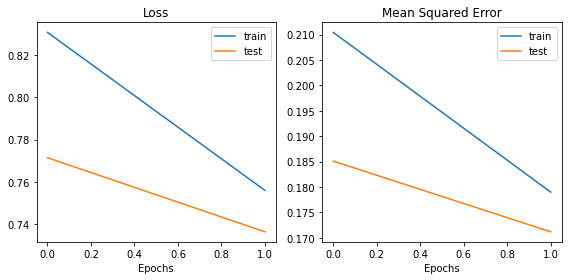

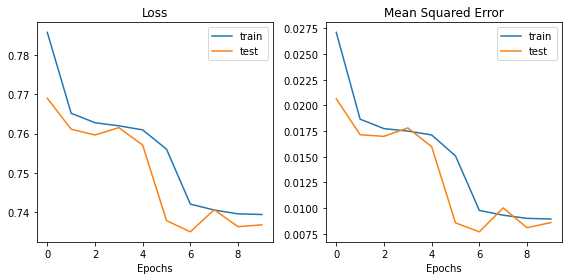

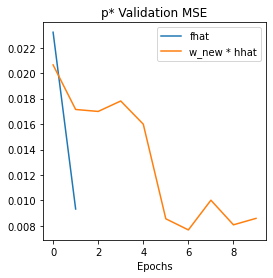

In [13]:
################## Model saving logisticcs
base_name = datetime.now().strftime("%m-%d-%Y_%H:%M:%S")
print("Time:", base_name)
os.mkdir("fhat_" + base_name)
os.mkdir("w_new_h_hat_" + base_name)
batch_size = 128


################## Callbacks
save_model1 = keras.callbacks.ModelCheckpoint(
    "fhat_" + base_name, monitor='val_mean_squared_error', verbose=1, save_best_only=True)

save_model2 = keras.callbacks.ModelCheckpoint(
    "w_new_h_hat_" + base_name, monitor='val_mean_squared_error', verbose=1, save_best_only=True)

s = np.concatenate((np.linspace(0, 0.1, 16)[1:], np.linspace(0.1, 0.005, 16)[1:], np.linspace(0, 0.005, 7)[-1:1:-1]))
n = len(s)
def schedule_outer(epoch, lr):
    if i > n:
        return lr * 0.96
    else:
        return s[i]
lr_scheduler_outer = tf.keras.callbacks.LearningRateScheduler(schedule_outer, verbose=1)

def schedule_inner(epoch, lr):
    return lr * 0.96
lr_scheduler_inner = tf.keras.callbacks.LearningRateScheduler(schedule_inner, verbose=1)

lr_reduce = keras.callbacks.ReduceLROnPlateau(
    monitor='val_mean_squared_error', factor=0.1, patience=1, verbose=1,
    mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)
        
class AdditionalValidationSets(keras.callbacks.Callback):
    def __init__(self, validation_sets, verbose=0, batch_size=None):
        super(AdditionalValidationSets, self).__init__()
        self.validation_sets = validation_sets
        for validation_set in self.validation_sets:
            if len(validation_set) != 3:
                raise ValueError()
        self.epoch = []
        self.history = {}
        self.verbose = verbose
        self.batch_size = batch_size

    def on_train_begin(self, logs=None):
        self.epoch = []
        self.history = {}

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        self.epoch.append(epoch)

        # record the same values as History() as well
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)

        # evaluate on the additional validation sets
        for validation_set in self.validation_sets:
            validation_data, validation_targets, validation_set_name = validation_set
            sample_weights = None

            results = self.model.evaluate(x=validation_data,
                                          y=validation_targets,
                                          verbose=self.verbose,
                                          sample_weight=sample_weights,
                                          batch_size=self.batch_size)

            for metric, result in zip(self.model.metrics_names,results):
                valuename = validation_set_name + '_' + metric
                self.history.setdefault(valuename, []).append(result)
                if self.verbose:
                    print(valuename + ": " + str(result))
                    

################## Model creation
small_resnet = tf.keras.applications.ResNet50V2(
    include_top=False, weights=None, input_tensor=None,
    input_shape=(32, 32, 1), pooling='max', classes=1,
    classifier_activation='sigmoid')

top1 = keras.models.Sequential([
    keras.layers.Dense(128, activation='tanh', 
                       kernel_initializer=keras.initializers.RandomUniform(), 
                       kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(64, activation='tanh', 
                       kernel_initializer=keras.initializers.RandomUniform(), 
                       kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1, activation='sigmoid', 
                       kernel_initializer=keras.initializers.RandomUniform(), 
                       kernel_regularizer=keras.regularizers.l2(0.001))
], name='w_hat')

opt = keras.optimizers.SGD(momentum=0.9)

fhat_model = keras.Sequential()
fhat_model.add(small_resnet)
fhat_model.add(top1)
fhat_model.compile(optimizer=opt,
                   loss=keras.losses.BinaryCrossentropy(),
                   metrics=[keras.metrics.MeanSquaredError(), 
                            keras.metrics.BinaryAccuracy()])
fhat_model.summary()


################## Training loop
n_epochs = 2
hists1 = []
hists2 = []

for i in range(n_epochs):
    fhat_data = AdditionalValidationSets([(x_test, y_test_old / 10., 'p*_val')], verbose=1, batch_size=batch_size)
    fhat_model.trainable = True
    fhat_model.fit(x=x_train, y=y_train, epochs=1, batch_size=batch_size, 
                   validation_data=(x_test, y_test), 
                   callbacks=[lr_scheduler_outer, save_model1, fhat_data,])
    fhat_model.evaluate(x_test, y_test_old / 10.)
    hists1.append(fhat_data)

    ftilde_data = AdditionalValidationSets([(x_test, y_test, 'y_val')], verbose=1, batch_size=batch_size)
    model = keras.Sequential()
    model.add(fhat_model.layers[0])
    fhat_model.trainable = False
    
    top2 = keras.models.Sequential([
        keras.layers.Dense(128, activation='tanh', 
                           kernel_initializer=keras.initializers.RandomUniform(), 
                           kernel_regularizer=keras.regularizers.l2(0.001)),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(64, activation='tanh', 
                           kernel_initializer=keras.initializers.RandomUniform(), 
                           kernel_regularizer=keras.regularizers.l2(0.001)),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(1, activation='sigmoid', 
                           kernel_initializer=keras.initializers.RandomUniform(), 
                           kernel_regularizer=keras.regularizers.l2(0.001))
    ], name='w_hat')
    
    model.add(top2)

    model.compile(optimizer=keras.optimizers.SGD(momentum=0.9),
                  loss=keras.losses.BinaryCrossentropy(),
                  metrics=[keras.metrics.MeanSquaredError()])

    model.fit(x=x_train, y=y_train_old / 10., epochs=5, batch_size=batch_size,
              validation_data=(x_test, y_test_old / 10.), 
              callbacks=[lr_scheduler_inner, save_model2, ftilde_data])
    hists2.append(ftilde_data)
    
    print(mse(fhat_model.predict(x_test), y_test_old / 10.))
    print(mse(model.predict(x_test), y_test_old / 10.))

    print(mae(fhat_model.predict(x_test), y_test_old / 10.))
    print(mae(model.predict(x_test), y_test_old / 10.))


################## Save results
total_hist1 = dict()
total_hist2 = dict()

for key in hists1[0].history.keys():
    current_values = [] 
    for hist_dict in hists1:
        hist_dict = hist_dict.history
        current_values += hist_dict[key]
    total_hist1[key] = current_values
    
for key in hists2[0].history.keys():
    current_values = [] 
    for hist_dict in hists2:
        hist_dict = hist_dict.history
        current_values += hist_dict[key]
    total_hist2[key] = current_values
    
json.dump(str(total_hist1), open("fhat_" + base_name + "/history.json", 'w'))
pickle.dump(total_hist1, open("fhat_" + base_name + "/history.pkl", 'wb'), pickle.HIGHEST_PROTOCOL)
json.dump(str(total_hist2), open("w_new_h_hat_" + base_name + "/history.json", 'w'))
pickle.dump(total_hist2, open("w_new_h_hat_" + base_name + "/history.pkl", 'wb'), pickle.HIGHEST_PROTOCOL)


################## Add some plots for good measure
fig, ax = plt.subplots(1, 2, figsize=(8,4))
ax[0].plot(total_hist1['loss'], label='train')
ax[0].plot(total_hist1['val_loss'], label='test')
ax[0].legend()
ax[0].set_title("Loss")
ax[0].set_xlabel("Epochs")
ax[1].plot(total_hist1['mean_squared_error'], label='train')
ax[1].plot(total_hist1['val_mean_squared_error'], label='test')
ax[1].legend()
ax[1].set_title("Mean Squared Error")
ax[1].set_xlabel("Epochs")
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(1, 2, figsize=(8,4))
ax[0].plot(total_hist2['loss'], label='train')
ax[0].plot(total_hist2['val_loss'], label='test')
ax[0].legend()
ax[0].set_title("Loss")
ax[0].set_xlabel("Epochs")
ax[1].plot(total_hist2['mean_squared_error'], label='train')
ax[1].plot(total_hist2['val_mean_squared_error'], label='test')
ax[1].legend()
ax[1].set_title("Mean Squared Error")
ax[1].set_xlabel("Epochs")
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(4,4))
ax.plot(total_hist1['p*_val_mean_squared_error'], label='fhat')
ax.plot(total_hist2['val_mean_squared_error'], label='w_new * hhat')
ax.legend()
ax.set_title("p* Validation MSE")
ax.set_xlabel("Epochs")
plt.show()


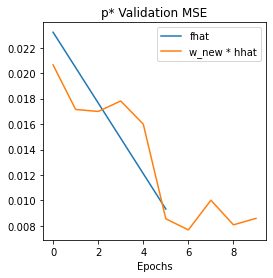

In [14]:
fig, ax = plt.subplots(figsize=(4,4))
ax.plot([0, 5], total_hist1['p*_val_mean_squared_error'], label='fhat')
ax.plot(total_hist2['val_mean_squared_error'], label='w_new * hhat')
ax.legend()
ax.set_title("p* Validation MSE")
ax.set_xlabel("Epochs")
plt.show()

# Cluster Test: Optimize Outer Loop Schedule
We based the outer training loop on something found on the internet. Let's verify for the 35 epochs that they tested that it's good. Otherwise, tweak the schedule as required. In the for loop below, we try the following
- Exponential decay at [0.99, 0.96, 0.90]
- The schedule from the website
- Fixed initial lr, reducing on plateau with factors of [1.5, 2, 10]

We will test each of these for 30 epochs. Once this test is finished, we will further attempt to optimize the inner loop schedule, L2 parameter, and droupout rate before training over the weekend. Finally, we will see how far we can drop the number of neurons in the dense layers.

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Functional)      (None, 2048)              23558528  
_________________________________________________________________
w_hat (Sequential)           (None, 1)                 270593    
Total params: 23,829,121
Trainable params: 23,783,681
Non-trainable params: 45,440
_________________________________________________________________
Epoch 1/30

Epoch 00001: LearningRateScheduler reducing learning rate to 0.006666666666666667.
469/469 [==============================] - 136s 286ms/step - loss: 0.8719 - mean_squared_error: 0.2283 - binary_accuracy: 0.6038 - val_loss: 0.8277 - val_mean_squared_error: 0.0463 - val_binary_accuracy: 0.0978
Epoch 2/30

Epoch 00002: LearningRateScheduler reducing learning rate to 0.013333333333333334.
469/469 [==============================] - 134s 285ms/step - loss: 0.7667 - mean_squared_error: 0

Epoch 26/30

Epoch 00026: LearningRateScheduler reducing learning rate to 0.030333333333333337.
469/469 [==============================] - 135s 288ms/step - loss: 0.6034 - mean_squared_error: 0.0970 - binary_accuracy: 0.8640 - val_loss: 1.1671 - val_mean_squared_error: 0.0952 - val_binary_accuracy: 0.0948
Epoch 27/30

Epoch 00027: LearningRateScheduler reducing learning rate to 0.024000000000000007.
469/469 [==============================] - 136s 289ms/step - loss: 0.5687 - mean_squared_error: 0.0839 - binary_accuracy: 0.8859 - val_loss: 1.2725 - val_mean_squared_error: 0.1018 - val_binary_accuracy: 0.0954
Epoch 28/30

Epoch 00028: LearningRateScheduler reducing learning rate to 0.017666666666666678.
469/469 [==============================] - 144s 307ms/step - loss: 0.5378 - mean_squared_error: 0.0736 - binary_accuracy: 0.9005 - val_loss: 1.3662 - val_mean_squared_error: 0.1128 - val_binary_accuracy: 0.0960
Epoch 29/30

Epoch 00029: LearningRateScheduler reducing learning rate to 0.011

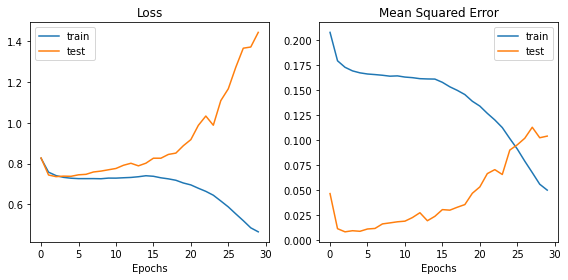

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Functional)      (None, 2048)              23558528  
_________________________________________________________________
w_hat (Sequential)           (None, 1)                 270593    
Total params: 23,829,121
Trainable params: 23,783,681
Non-trainable params: 45,440
_________________________________________________________________
Epoch 1/30

Epoch 00001: LearningRateScheduler reducing learning rate to 0.009899999778717757.
469/469 [==============================] - 150s 313ms/step - loss: 0.8621 - mean_squared_error: 0.2239 - binary_accuracy: 0.6191 - val_loss: 0.7737 - val_mean_squared_error: 0.0226 - val_binary_accuracy: 0.0964
Epoch 2/30

Epoch 00002: LearningRateScheduler reducing learning rate to 0.009800999946892262.
469/469 [==============================] - ETA: 0s - loss: 0.7532 - mean_squared_error: 0.1775 - 

In [ ]:
################## Callbacks
s = np.concatenate((np.linspace(0, 0.1, 16)[1:], np.linspace(0.1, 0.005, 16)[1:], np.linspace(0, 0.005, 7)[-1:1:-1]))
n = len(s)
def schedule_outer(epoch, lr):
    if epoch > n:
        return lr * 0.96
    else:
        return s[epoch]
lr_scheduler_outer = tf.keras.callbacks.LearningRateScheduler(schedule_outer, verbose=1)

lr_reduce = keras.callbacks.ReduceLROnPlateau(
    monitor='val_mean_squared_error', factor=0.1, patience=1, verbose=1,
    mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)
        
class AdditionalValidationSets(keras.callbacks.Callback):
    def __init__(self, validation_sets, verbose=0, batch_size=None):
        """
        From https://stackoverflow.com/questions/47731935/using-multiple-validation-sets-with-keras
        :param validation_sets:
        a list of 3-tuples (validation_data, validation_targets, validation_set_name)
        or 4-tuples (validation_data, validation_targets, sample_weights, validation_set_name)
        :param verbose:
        verbosity mode, 1 or 0
        :param batch_size:
        batch size to be used when evaluating on the additional datasets
        """
        super(AdditionalValidationSets, self).__init__()
        self.validation_sets = validation_sets
        for validation_set in self.validation_sets:
            if len(validation_set) not in [3, 4]:
                raise ValueError()
        self.epoch = []
        self.history = {}
        self.verbose = verbose
        self.batch_size = batch_size

    def on_train_begin(self, logs=None):
        self.epoch = []
        self.history = {}

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        self.epoch.append(epoch)

        # record the same values as History() as well
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)

        # evaluate on the additional validation sets
        for validation_set in self.validation_sets:
            if len(validation_set) == 3:
                validation_data, validation_targets, validation_set_name = validation_set
                sample_weights = None
            elif len(validation_set) == 4:
                validation_data, validation_targets, sample_weights, validation_set_name = validation_set
            else:
                raise ValueError()

            results = self.model.evaluate(x=validation_data,
                                          y=validation_targets,
                                          verbose=self.verbose,
                                          sample_weight=sample_weights,
                                          batch_size=self.batch_size)

            for metric, result in zip(self.model.metrics_names,results):
                valuename = validation_set_name + '_' + metric
                self.history.setdefault(valuename, []).append(result)
                if self.verbose:
                    print(valuename + ": " + str(result))
fhat_data = AdditionalValidationSets([(x_test, y_test_old / 10., 'p*_mse')], verbose=1, batch_size=batch_size)
ftilde_data = AdditionalValidationSets([(x_test, y_test, 'y_mse')], verbose=1, batch_size=batch_size)


################## Model creation
small_resnet = tf.keras.applications.ResNet50V2(
    include_top=False, weights=None, input_tensor=None,
    input_shape=(32, 32, 1), pooling='max', classes=1,
    classifier_activation='sigmoid')

top1 = keras.models.Sequential([
    keras.layers.Dense(128, activation='tanh', 
                       kernel_initializer=keras.initializers.RandomUniform(), 
                       kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(64, activation='tanh', 
                       kernel_initializer=keras.initializers.RandomUniform(), 
                       kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1, activation='sigmoid', 
                       kernel_initializer=keras.initializers.RandomUniform(), 
                       kernel_regularizer=keras.regularizers.l2(0.001))
], name='w_hat')

opt = keras.optimizers.SGD(momentum=0.9)

fhat_model = keras.Sequential()
fhat_model.add(small_resnet)
fhat_model.add(top1)
fhat_model.compile(optimizer=opt,
                   loss=keras.losses.BinaryCrossentropy(),
                   metrics=[keras.metrics.MeanSquaredError(), 
                            keras.metrics.BinaryAccuracy()])
fhat_model.summary()


################## Training loop
hists1 = []
hists2 = []

fhat_model.trainable = True
fhat_model.fit(x=x_train, y=y_train, epochs=35, batch_size=batch_size, 
               validation_data=(x_test, y_test), 
               callbacks=[lr_scheduler_outer, fhat_data,])
hists1.append(fhat_data)

total_hist1 = dict()

for key in hists1[0].history.keys():
    current_values = [] 
    for hist_dict in hists1:
        hist_dict = hist_dict.history
        current_values += hist_dict[key]
    total_hist1[key] = current_values
    

################## Add some plots for good measure
fig, ax = plt.subplots(1, 2, figsize=(8,4))
ax[0].plot(total_hist1['loss'], label='train')
ax[0].plot(total_hist1['val_loss'], label='test')
ax[0].legend()
ax[0].set_title("Loss")
ax[0].set_xlabel("Epochs")
ax[1].plot(total_hist1['mean_squared_error'], label='train')
ax[1].plot(total_hist1['val_mean_squared_error'], label='test')
ax[1].legend()
ax[1].set_title("Mean Squared Error")
ax[1].set_xlabel("Epochs")
plt.tight_layout()
plt.show()


############################################################################################################
############################################################################################################


################## Callbacks
s = np.concatenate((np.linspace(0, 0.1, 16)[1:], np.linspace(0.1, 0.005, 16)[1:], np.linspace(0, 0.005, 7)[-1:1:-1]))
n = len(s)
def schedule_outer(epoch, lr):
    return lr * 0.99
lr_scheduler_outer = tf.keras.callbacks.LearningRateScheduler(schedule_outer, verbose=1)

lr_reduce = keras.callbacks.ReduceLROnPlateau(
    monitor='val_mean_squared_error', factor=0.1, patience=1, verbose=1,
    mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)
        
class AdditionalValidationSets(keras.callbacks.Callback):
    def __init__(self, validation_sets, verbose=0, batch_size=None):
        """
        From https://stackoverflow.com/questions/47731935/using-multiple-validation-sets-with-keras
        :param validation_sets:
        a list of 3-tuples (validation_data, validation_targets, validation_set_name)
        or 4-tuples (validation_data, validation_targets, sample_weights, validation_set_name)
        :param verbose:
        verbosity mode, 1 or 0
        :param batch_size:
        batch size to be used when evaluating on the additional datasets
        """
        super(AdditionalValidationSets, self).__init__()
        self.validation_sets = validation_sets
        for validation_set in self.validation_sets:
            if len(validation_set) not in [3, 4]:
                raise ValueError()
        self.epoch = []
        self.history = {}
        self.verbose = verbose
        self.batch_size = batch_size

    def on_train_begin(self, logs=None):
        self.epoch = []
        self.history = {}

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        self.epoch.append(epoch)

        # record the same values as History() as well
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)

        # evaluate on the additional validation sets
        for validation_set in self.validation_sets:
            if len(validation_set) == 3:
                validation_data, validation_targets, validation_set_name = validation_set
                sample_weights = None
            elif len(validation_set) == 4:
                validation_data, validation_targets, sample_weights, validation_set_name = validation_set
            else:
                raise ValueError()

            results = self.model.evaluate(x=validation_data,
                                          y=validation_targets,
                                          verbose=self.verbose,
                                          sample_weight=sample_weights,
                                          batch_size=self.batch_size)

            for metric, result in zip(self.model.metrics_names,results):
                valuename = validation_set_name + '_' + metric
                self.history.setdefault(valuename, []).append(result)
                if self.verbose:
                    print(valuename + ": " + str(result))
fhat_data = AdditionalValidationSets([(x_test, y_test_old / 10., 'p*_mse')], verbose=1, batch_size=batch_size)
ftilde_data = AdditionalValidationSets([(x_test, y_test, 'y_mse')], verbose=1, batch_size=batch_size)


################## Model creation
small_resnet = tf.keras.applications.ResNet50V2(
    include_top=False, weights=None, input_tensor=None,
    input_shape=(32, 32, 1), pooling='max', classes=1,
    classifier_activation='sigmoid')

top1 = keras.models.Sequential([
    keras.layers.Dense(128, activation='tanh', 
                       kernel_initializer=keras.initializers.RandomUniform(), 
                       kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(64, activation='tanh', 
                       kernel_initializer=keras.initializers.RandomUniform(), 
                       kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1, activation='sigmoid', 
                       kernel_initializer=keras.initializers.RandomUniform(), 
                       kernel_regularizer=keras.regularizers.l2(0.001))
], name='w_hat')

opt = keras.optimizers.SGD(momentum=0.9)

fhat_model = keras.Sequential()
fhat_model.add(small_resnet)
fhat_model.add(top1)
fhat_model.compile(optimizer=opt,
                   loss=keras.losses.BinaryCrossentropy(),
                   metrics=[keras.metrics.MeanSquaredError(), 
                            keras.metrics.BinaryAccuracy()])
fhat_model.summary()


################## Training loop
hists1 = []
hists2 = []

fhat_model.trainable = True
fhat_model.fit(x=x_train, y=y_train, epochs=35, batch_size=batch_size, 
               validation_data=(x_test, y_test), 
               callbacks=[lr_scheduler_outer, fhat_data,])
hists1.append(fhat_data)

total_hist1 = dict()

for key in hists1[0].history.keys():
    current_values = [] 
    for hist_dict in hists1:
        hist_dict = hist_dict.history
        current_values += hist_dict[key]
    total_hist1[key] = current_values
    

################## Add some plots for good measure
fig, ax = plt.subplots(1, 2, figsize=(8,4))
ax[0].plot(total_hist1['loss'], label='train')
ax[0].plot(total_hist1['val_loss'], label='test')
ax[0].legend()
ax[0].set_title("Loss")
ax[0].set_xlabel("Epochs")
ax[1].plot(total_hist1['mean_squared_error'], label='train')
ax[1].plot(total_hist1['val_mean_squared_error'], label='test')
ax[1].legend()
ax[1].set_title("Mean Squared Error")
ax[1].set_xlabel("Epochs")
plt.tight_layout()
plt.show()


############################################################################################################
############################################################################################################


################## Callbacks
s = np.concatenate((np.linspace(0, 0.1, 16)[1:], np.linspace(0.1, 0.005, 16)[1:], np.linspace(0, 0.005, 7)[-1:1:-1]))
n = len(s)
def schedule_outer(epoch, lr):
    return lr * 0.96
lr_scheduler_outer = tf.keras.callbacks.LearningRateScheduler(schedule_outer, verbose=1)

lr_reduce = keras.callbacks.ReduceLROnPlateau(
    monitor='val_mean_squared_error', factor=0.1, patience=1, verbose=1,
    mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)
        
class AdditionalValidationSets(keras.callbacks.Callback):
    def __init__(self, validation_sets, verbose=0, batch_size=None):
        """
        From https://stackoverflow.com/questions/47731935/using-multiple-validation-sets-with-keras
        :param validation_sets:
        a list of 3-tuples (validation_data, validation_targets, validation_set_name)
        or 4-tuples (validation_data, validation_targets, sample_weights, validation_set_name)
        :param verbose:
        verbosity mode, 1 or 0
        :param batch_size:
        batch size to be used when evaluating on the additional datasets
        """
        super(AdditionalValidationSets, self).__init__()
        self.validation_sets = validation_sets
        for validation_set in self.validation_sets:
            if len(validation_set) not in [3, 4]:
                raise ValueError()
        self.epoch = []
        self.history = {}
        self.verbose = verbose
        self.batch_size = batch_size

    def on_train_begin(self, logs=None):
        self.epoch = []
        self.history = {}

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        self.epoch.append(epoch)

        # record the same values as History() as well
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)

        # evaluate on the additional validation sets
        for validation_set in self.validation_sets:
            if len(validation_set) == 3:
                validation_data, validation_targets, validation_set_name = validation_set
                sample_weights = None
            elif len(validation_set) == 4:
                validation_data, validation_targets, sample_weights, validation_set_name = validation_set
            else:
                raise ValueError()

            results = self.model.evaluate(x=validation_data,
                                          y=validation_targets,
                                          verbose=self.verbose,
                                          sample_weight=sample_weights,
                                          batch_size=self.batch_size)

            for metric, result in zip(self.model.metrics_names,results):
                valuename = validation_set_name + '_' + metric
                self.history.setdefault(valuename, []).append(result)
                if self.verbose:
                    print(valuename + ": " + str(result))
fhat_data = AdditionalValidationSets([(x_test, y_test_old / 10., 'p*_mse')], verbose=1, batch_size=batch_size)
ftilde_data = AdditionalValidationSets([(x_test, y_test, 'y_mse')], verbose=1, batch_size=batch_size)


################## Model creation
small_resnet = tf.keras.applications.ResNet50V2(
    include_top=False, weights=None, input_tensor=None,
    input_shape=(32, 32, 1), pooling='max', classes=1,
    classifier_activation='sigmoid')

top1 = keras.models.Sequential([
    keras.layers.Dense(128, activation='tanh', 
                       kernel_initializer=keras.initializers.RandomUniform(), 
                       kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(64, activation='tanh', 
                       kernel_initializer=keras.initializers.RandomUniform(), 
                       kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1, activation='sigmoid', 
                       kernel_initializer=keras.initializers.RandomUniform(), 
                       kernel_regularizer=keras.regularizers.l2(0.001))
], name='w_hat')

opt = keras.optimizers.SGD(momentum=0.9)

fhat_model = keras.Sequential()
fhat_model.add(small_resnet)
fhat_model.add(top1)
fhat_model.compile(optimizer=opt,
                   loss=keras.losses.BinaryCrossentropy(),
                   metrics=[keras.metrics.MeanSquaredError(), 
                            keras.metrics.BinaryAccuracy()])
fhat_model.summary()


################## Training loop
hists1 = []
hists2 = []

fhat_model.trainable = True
fhat_model.fit(x=x_train, y=y_train, epochs=35, batch_size=batch_size, 
               validation_data=(x_test, y_test), 
               callbacks=[lr_scheduler_outer, fhat_data,])
hists1.append(fhat_data)

total_hist1 = dict()

for key in hists1[0].history.keys():
    current_values = [] 
    for hist_dict in hists1:
        hist_dict = hist_dict.history
        current_values += hist_dict[key]
    total_hist1[key] = current_values
    

################## Add some plots for good measure
fig, ax = plt.subplots(1, 2, figsize=(8,4))
ax[0].plot(total_hist1['loss'], label='train')
ax[0].plot(total_hist1['val_loss'], label='test')
ax[0].legend()
ax[0].set_title("Loss")
ax[0].set_xlabel("Epochs")
ax[1].plot(total_hist1['mean_squared_error'], label='train')
ax[1].plot(total_hist1['val_mean_squared_error'], label='test')
ax[1].legend()
ax[1].set_title("Mean Squared Error")
ax[1].set_xlabel("Epochs")
plt.tight_layout()
plt.show()


############################################################################################################
############################################################################################################


################## Callbacks
s = np.concatenate((np.linspace(0, 0.1, 16)[1:], np.linspace(0.1, 0.005, 16)[1:], np.linspace(0, 0.005, 7)[-1:1:-1]))
n = len(s)
def schedule_outer(epoch, lr):
    return lr * 0.93
lr_scheduler_outer = tf.keras.callbacks.LearningRateScheduler(schedule_outer, verbose=1)

lr_reduce = keras.callbacks.ReduceLROnPlateau(
    monitor='val_mean_squared_error', factor=0.1, patience=1, verbose=1,
    mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)
        
class AdditionalValidationSets(keras.callbacks.Callback):
    def __init__(self, validation_sets, verbose=0, batch_size=None):
        """
        From https://stackoverflow.com/questions/47731935/using-multiple-validation-sets-with-keras
        :param validation_sets:
        a list of 3-tuples (validation_data, validation_targets, validation_set_name)
        or 4-tuples (validation_data, validation_targets, sample_weights, validation_set_name)
        :param verbose:
        verbosity mode, 1 or 0
        :param batch_size:
        batch size to be used when evaluating on the additional datasets
        """
        super(AdditionalValidationSets, self).__init__()
        self.validation_sets = validation_sets
        for validation_set in self.validation_sets:
            if len(validation_set) not in [3, 4]:
                raise ValueError()
        self.epoch = []
        self.history = {}
        self.verbose = verbose
        self.batch_size = batch_size

    def on_train_begin(self, logs=None):
        self.epoch = []
        self.history = {}

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        self.epoch.append(epoch)

        # record the same values as History() as well
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)

        # evaluate on the additional validation sets
        for validation_set in self.validation_sets:
            if len(validation_set) == 3:
                validation_data, validation_targets, validation_set_name = validation_set
                sample_weights = None
            elif len(validation_set) == 4:
                validation_data, validation_targets, sample_weights, validation_set_name = validation_set
            else:
                raise ValueError()

            results = self.model.evaluate(x=validation_data,
                                          y=validation_targets,
                                          verbose=self.verbose,
                                          sample_weight=sample_weights,
                                          batch_size=self.batch_size)

            for metric, result in zip(self.model.metrics_names,results):
                valuename = validation_set_name + '_' + metric
                self.history.setdefault(valuename, []).append(result)
                if self.verbose:
                    print(valuename + ": " + str(result))
fhat_data = AdditionalValidationSets([(x_test, y_test_old / 10., 'p*_mse')], verbose=1, batch_size=batch_size)
ftilde_data = AdditionalValidationSets([(x_test, y_test, 'y_mse')], verbose=1, batch_size=batch_size)


################## Model creation
small_resnet = tf.keras.applications.ResNet50V2(
    include_top=False, weights=None, input_tensor=None,
    input_shape=(32, 32, 1), pooling='max', classes=1,
    classifier_activation='sigmoid')

top1 = keras.models.Sequential([
    keras.layers.Dense(128, activation='tanh', 
                       kernel_initializer=keras.initializers.RandomUniform(), 
                       kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(64, activation='tanh', 
                       kernel_initializer=keras.initializers.RandomUniform(), 
                       kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1, activation='sigmoid', 
                       kernel_initializer=keras.initializers.RandomUniform(), 
                       kernel_regularizer=keras.regularizers.l2(0.001))
], name='w_hat')

opt = keras.optimizers.SGD(momentum=0.9)

fhat_model = keras.Sequential()
fhat_model.add(small_resnet)
fhat_model.add(top1)
fhat_model.compile(optimizer=opt,
                   loss=keras.losses.BinaryCrossentropy(),
                   metrics=[keras.metrics.MeanSquaredError(), 
                            keras.metrics.BinaryAccuracy()])
fhat_model.summary()


################## Training loop
hists1 = []
hists2 = []

fhat_model.trainable = True
fhat_model.fit(x=x_train, y=y_train, epochs=35, batch_size=batch_size, 
               validation_data=(x_test, y_test), 
               callbacks=[lr_scheduler_outer, fhat_data,])
hists1.append(fhat_data)

total_hist1 = dict()

for key in hists1[0].history.keys():
    current_values = [] 
    for hist_dict in hists1:
        hist_dict = hist_dict.history
        current_values += hist_dict[key]
    total_hist1[key] = current_values
    

################## Add some plots for good measure
fig, ax = plt.subplots(1, 2, figsize=(8,4))
ax[0].plot(total_hist1['loss'], label='train')
ax[0].plot(total_hist1['val_loss'], label='test')
ax[0].legend()
ax[0].set_title("Loss")
ax[0].set_xlabel("Epochs")
ax[1].plot(total_hist1['mean_squared_error'], label='train')
ax[1].plot(total_hist1['val_mean_squared_error'], label='test')
ax[1].legend()
ax[1].set_title("Mean Squared Error")
ax[1].set_xlabel("Epochs")
plt.tight_layout()
plt.show()


############################################################################################################
############################################################################################################


################## Callbacks
s = np.concatenate((np.linspace(0, 0.1, 16)[1:], np.linspace(0.1, 0.005, 16)[1:], np.linspace(0, 0.005, 7)[-1:1:-1]))
n = len(s)

lr_reduce = keras.callbacks.ReduceLROnPlateau(
    monitor='val_mean_squared_error', factor=0.1, patience=1, verbose=1,
    mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)
        
class AdditionalValidationSets(keras.callbacks.Callback):
    def __init__(self, validation_sets, verbose=0, batch_size=None):
        """
        From https://stackoverflow.com/questions/47731935/using-multiple-validation-sets-with-keras
        :param validation_sets:
        a list of 3-tuples (validation_data, validation_targets, validation_set_name)
        or 4-tuples (validation_data, validation_targets, sample_weights, validation_set_name)
        :param verbose:
        verbosity mode, 1 or 0
        :param batch_size:
        batch size to be used when evaluating on the additional datasets
        """
        super(AdditionalValidationSets, self).__init__()
        self.validation_sets = validation_sets
        for validation_set in self.validation_sets:
            if len(validation_set) not in [3, 4]:
                raise ValueError()
        self.epoch = []
        self.history = {}
        self.verbose = verbose
        self.batch_size = batch_size

    def on_train_begin(self, logs=None):
        self.epoch = []
        self.history = {}

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        self.epoch.append(epoch)

        # record the same values as History() as well
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)

        # evaluate on the additional validation sets
        for validation_set in self.validation_sets:
            if len(validation_set) == 3:
                validation_data, validation_targets, validation_set_name = validation_set
                sample_weights = None
            elif len(validation_set) == 4:
                validation_data, validation_targets, sample_weights, validation_set_name = validation_set
            else:
                raise ValueError()

            results = self.model.evaluate(x=validation_data,
                                          y=validation_targets,
                                          verbose=self.verbose,
                                          sample_weight=sample_weights,
                                          batch_size=self.batch_size)

            for metric, result in zip(self.model.metrics_names,results):
                valuename = validation_set_name + '_' + metric
                self.history.setdefault(valuename, []).append(result)
                if self.verbose:
                    print(valuename + ": " + str(result))
fhat_data = AdditionalValidationSets([(x_test, y_test_old / 10., 'p*_mse')], verbose=1, batch_size=batch_size)
ftilde_data = AdditionalValidationSets([(x_test, y_test, 'y_mse')], verbose=1, batch_size=batch_size)


################## Model creation
small_resnet = tf.keras.applications.ResNet50V2(
    include_top=False, weights=None, input_tensor=None,
    input_shape=(32, 32, 1), pooling='max', classes=1,
    classifier_activation='sigmoid')

top1 = keras.models.Sequential([
    keras.layers.Dense(128, activation='tanh', 
                       kernel_initializer=keras.initializers.RandomUniform(), 
                       kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(64, activation='tanh', 
                       kernel_initializer=keras.initializers.RandomUniform(), 
                       kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1, activation='sigmoid', 
                       kernel_initializer=keras.initializers.RandomUniform(), 
                       kernel_regularizer=keras.regularizers.l2(0.001))
], name='w_hat')

opt = keras.optimizers.SGD(momentum=0.9)

fhat_model = keras.Sequential()
fhat_model.add(small_resnet)
fhat_model.add(top1)
fhat_model.compile(optimizer=opt,
                   loss=keras.losses.BinaryCrossentropy(),
                   metrics=[keras.metrics.MeanSquaredError(), 
                            keras.metrics.BinaryAccuracy()])
fhat_model.summary()


################## Training loop
hists1 = []
hists2 = []

fhat_model.trainable = True
fhat_model.fit(x=x_train, y=y_train, epochs=35, batch_size=batch_size, 
               validation_data=(x_test, y_test), 
               callbacks=[fhat_data, lr_reduce])
hists1.append(fhat_data)

total_hist1 = dict()

for key in hists1[0].history.keys():
    current_values = [] 
    for hist_dict in hists1:
        hist_dict = hist_dict.history
        current_values += hist_dict[key]
    total_hist1[key] = current_values
    

################## Add some plots for good measure
fig, ax = plt.subplots(1, 2, figsize=(8,4))
ax[0].plot(total_hist1['loss'], label='train')
ax[0].plot(total_hist1['val_loss'], label='test')
ax[0].legend()
ax[0].set_title("Loss")
ax[0].set_xlabel("Epochs")
ax[1].plot(total_hist1['mean_squared_error'], label='train')
ax[1].plot(total_hist1['val_mean_squared_error'], label='test')
ax[1].legend()
ax[1].set_title("Mean Squared Error")
ax[1].set_xlabel("Epochs")
plt.tight_layout()
plt.show()


############################################################################################################
############################################################################################################


################## Callbacks
s = np.concatenate((np.linspace(0, 0.1, 16)[1:], np.linspace(0.1, 0.005, 16)[1:], np.linspace(0, 0.005, 7)[-1:1:-1]))
n = len(s)

lr_reduce = keras.callbacks.ReduceLROnPlateau(
    monitor='val_mean_squared_error', factor=0.5, patience=1, verbose=1,
    mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)
        
class AdditionalValidationSets(keras.callbacks.Callback):
    def __init__(self, validation_sets, verbose=0, batch_size=None):
        """
        From https://stackoverflow.com/questions/47731935/using-multiple-validation-sets-with-keras
        :param validation_sets:
        a list of 3-tuples (validation_data, validation_targets, validation_set_name)
        or 4-tuples (validation_data, validation_targets, sample_weights, validation_set_name)
        :param verbose:
        verbosity mode, 1 or 0
        :param batch_size:
        batch size to be used when evaluating on the additional datasets
        """
        super(AdditionalValidationSets, self).__init__()
        self.validation_sets = validation_sets
        for validation_set in self.validation_sets:
            if len(validation_set) not in [3, 4]:
                raise ValueError()
        self.epoch = []
        self.history = {}
        self.verbose = verbose
        self.batch_size = batch_size

    def on_train_begin(self, logs=None):
        self.epoch = []
        self.history = {}

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        self.epoch.append(epoch)

        # record the same values as History() as well
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)

        # evaluate on the additional validation sets
        for validation_set in self.validation_sets:
            if len(validation_set) == 3:
                validation_data, validation_targets, validation_set_name = validation_set
                sample_weights = None
            elif len(validation_set) == 4:
                validation_data, validation_targets, sample_weights, validation_set_name = validation_set
            else:
                raise ValueError()

            results = self.model.evaluate(x=validation_data,
                                          y=validation_targets,
                                          verbose=self.verbose,
                                          sample_weight=sample_weights,
                                          batch_size=self.batch_size)

            for metric, result in zip(self.model.metrics_names,results):
                valuename = validation_set_name + '_' + metric
                self.history.setdefault(valuename, []).append(result)
                if self.verbose:
                    print(valuename + ": " + str(result))
fhat_data = AdditionalValidationSets([(x_test, y_test_old / 10., 'p*_mse')], verbose=1, batch_size=batch_size)
ftilde_data = AdditionalValidationSets([(x_test, y_test, 'y_mse')], verbose=1, batch_size=batch_size)


################## Model creation
small_resnet = tf.keras.applications.ResNet50V2(
    include_top=False, weights=None, input_tensor=None,
    input_shape=(32, 32, 1), pooling='max', classes=1,
    classifier_activation='sigmoid')

top1 = keras.models.Sequential([
    keras.layers.Dense(128, activation='tanh', 
                       kernel_initializer=keras.initializers.RandomUniform(), 
                       kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(64, activation='tanh', 
                       kernel_initializer=keras.initializers.RandomUniform(), 
                       kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1, activation='sigmoid', 
                       kernel_initializer=keras.initializers.RandomUniform(), 
                       kernel_regularizer=keras.regularizers.l2(0.001))
], name='w_hat')

opt = keras.optimizers.SGD(momentum=0.9)

fhat_model = keras.Sequential()
fhat_model.add(small_resnet)
fhat_model.add(top1)
fhat_model.compile(optimizer=opt,
                   loss=keras.losses.BinaryCrossentropy(),
                   metrics=[keras.metrics.MeanSquaredError(), 
                            keras.metrics.BinaryAccuracy()])
fhat_model.summary()


################## Training loop
hists1 = []
hists2 = []

fhat_model.trainable = True
fhat_model.fit(x=x_train, y=y_train, epochs=35, batch_size=batch_size, 
               validation_data=(x_test, y_test), 
               callbacks=[fhat_data, lr_reduce])
hists1.append(fhat_data)

total_hist1 = dict()

for key in hists1[0].history.keys():
    current_values = [] 
    for hist_dict in hists1:
        hist_dict = hist_dict.history
        current_values += hist_dict[key]
    total_hist1[key] = current_values
    

################## Add some plots for good measure
fig, ax = plt.subplots(1, 2, figsize=(8,4))
ax[0].plot(total_hist1['loss'], label='train')
ax[0].plot(total_hist1['val_loss'], label='test')
ax[0].legend()
ax[0].set_title("Loss")
ax[0].set_xlabel("Epochs")
ax[1].plot(total_hist1['mean_squared_error'], label='train')
ax[1].plot(total_hist1['val_mean_squared_error'], label='test')
ax[1].legend()
ax[1].set_title("Mean Squared Error")
ax[1].set_xlabel("Epochs")
plt.tight_layout()
plt.show()


############################################################################################################
############################################################################################################


################## Callbacks
s = np.concatenate((np.linspace(0, 0.1, 16)[1:], np.linspace(0.1, 0.005, 16)[1:], np.linspace(0, 0.005, 7)[-1:1:-1]))
n = len(s)

lr_reduce = keras.callbacks.ReduceLROnPlateau(
    monitor='val_mean_squared_error', factor=0.7, patience=1, verbose=1,
    mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)
        
class AdditionalValidationSets(keras.callbacks.Callback):
    def __init__(self, validation_sets, verbose=0, batch_size=None):
        """
        From https://stackoverflow.com/questions/47731935/using-multiple-validation-sets-with-keras
        :param validation_sets:
        a list of 3-tuples (validation_data, validation_targets, validation_set_name)
        or 4-tuples (validation_data, validation_targets, sample_weights, validation_set_name)
        :param verbose:
        verbosity mode, 1 or 0
        :param batch_size:
        batch size to be used when evaluating on the additional datasets
        """
        super(AdditionalValidationSets, self).__init__()
        self.validation_sets = validation_sets
        for validation_set in self.validation_sets:
            if len(validation_set) not in [3, 4]:
                raise ValueError()
        self.epoch = []
        self.history = {}
        self.verbose = verbose
        self.batch_size = batch_size

    def on_train_begin(self, logs=None):
        self.epoch = []
        self.history = {}

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        self.epoch.append(epoch)

        # record the same values as History() as well
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)

        # evaluate on the additional validation sets
        for validation_set in self.validation_sets:
            if len(validation_set) == 3:
                validation_data, validation_targets, validation_set_name = validation_set
                sample_weights = None
            elif len(validation_set) == 4:
                validation_data, validation_targets, sample_weights, validation_set_name = validation_set
            else:
                raise ValueError()

            results = self.model.evaluate(x=validation_data,
                                          y=validation_targets,
                                          verbose=self.verbose,
                                          sample_weight=sample_weights,
                                          batch_size=self.batch_size)

            for metric, result in zip(self.model.metrics_names,results):
                valuename = validation_set_name + '_' + metric
                self.history.setdefault(valuename, []).append(result)
                if self.verbose:
                    print(valuename + ": " + str(result))
fhat_data = AdditionalValidationSets([(x_test, y_test_old / 10., 'p*_mse')], verbose=1, batch_size=batch_size)
ftilde_data = AdditionalValidationSets([(x_test, y_test, 'y_mse')], verbose=1, batch_size=batch_size)


################## Model creation
small_resnet = tf.keras.applications.ResNet50V2(
    include_top=False, weights=None, input_tensor=None,
    input_shape=(32, 32, 1), pooling='max', classes=1,
    classifier_activation='sigmoid')

top1 = keras.models.Sequential([
    keras.layers.Dense(128, activation='tanh', 
                       kernel_initializer=keras.initializers.RandomUniform(), 
                       kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(64, activation='tanh', 
                       kernel_initializer=keras.initializers.RandomUniform(), 
                       kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1, activation='sigmoid', 
                       kernel_initializer=keras.initializers.RandomUniform(), 
                       kernel_regularizer=keras.regularizers.l2(0.001))
], name='w_hat')

opt = keras.optimizers.SGD(momentum=0.9)

fhat_model = keras.Sequential()
fhat_model.add(small_resnet)
fhat_model.add(top1)
fhat_model.compile(optimizer=opt,
                   loss=keras.losses.BinaryCrossentropy(),
                   metrics=[keras.metrics.MeanSquaredError(), 
                            keras.metrics.BinaryAccuracy()])
fhat_model.summary()


################## Training loop
hists1 = []
hists2 = []

fhat_model.trainable = True
fhat_model.fit(x=x_train, y=y_train, epochs=35, batch_size=batch_size, 
               validation_data=(x_test, y_test), 
               callbacks=[fhat_data, lr_reduce])
hists1.append(fhat_data)

total_hist1 = dict()

for key in hists1[0].history.keys():
    current_values = [] 
    for hist_dict in hists1:
        hist_dict = hist_dict.history
        current_values += hist_dict[key]
    total_hist1[key] = current_values
    

################## Add some plots for good measure
fig, ax = plt.subplots(1, 2, figsize=(8,4))
ax[0].plot(total_hist1['loss'], label='train')
ax[0].plot(total_hist1['val_loss'], label='test')
ax[0].legend()
ax[0].set_title("Loss")
ax[0].set_xlabel("Epochs")
ax[1].plot(total_hist1['mean_squared_error'], label='train')
ax[1].plot(total_hist1['val_mean_squared_error'], label='test')
ax[1].legend()
ax[1].set_title("Mean Squared Error")
ax[1].set_xlabel("Epochs")
plt.tight_layout()
plt.show()

